<a href="https://colab.research.google.com/github/icarocarmona/Tech-Challenges-DTAT-Grupo-26/blob/main/Machine_Learning_and_Time_Series/Tech_Challenge_Prediction_Stock_Prices_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow

In [2]:
!pip install -q yfinance

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import LSTM, Dense, Reshape
from tensorflow.keras.models import Sequential
import plotly.graph_objs as go

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
import yfinance as yf

symbol = '^BVSP'
start_date = '2018-01-01'
end_date = '2024-01-31'

bvsp_full = yf.download(symbol, start=start_date, end=end_date)

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


# Analise exploratoria

In [5]:
bvsp_full.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,76403.0,77909.0,76403.0,77891.0,77891.0,2880300
2018-01-03,77889.0,78414.0,77602.0,77995.0,77995.0,3142200


<Axes: xlabel='Date'>

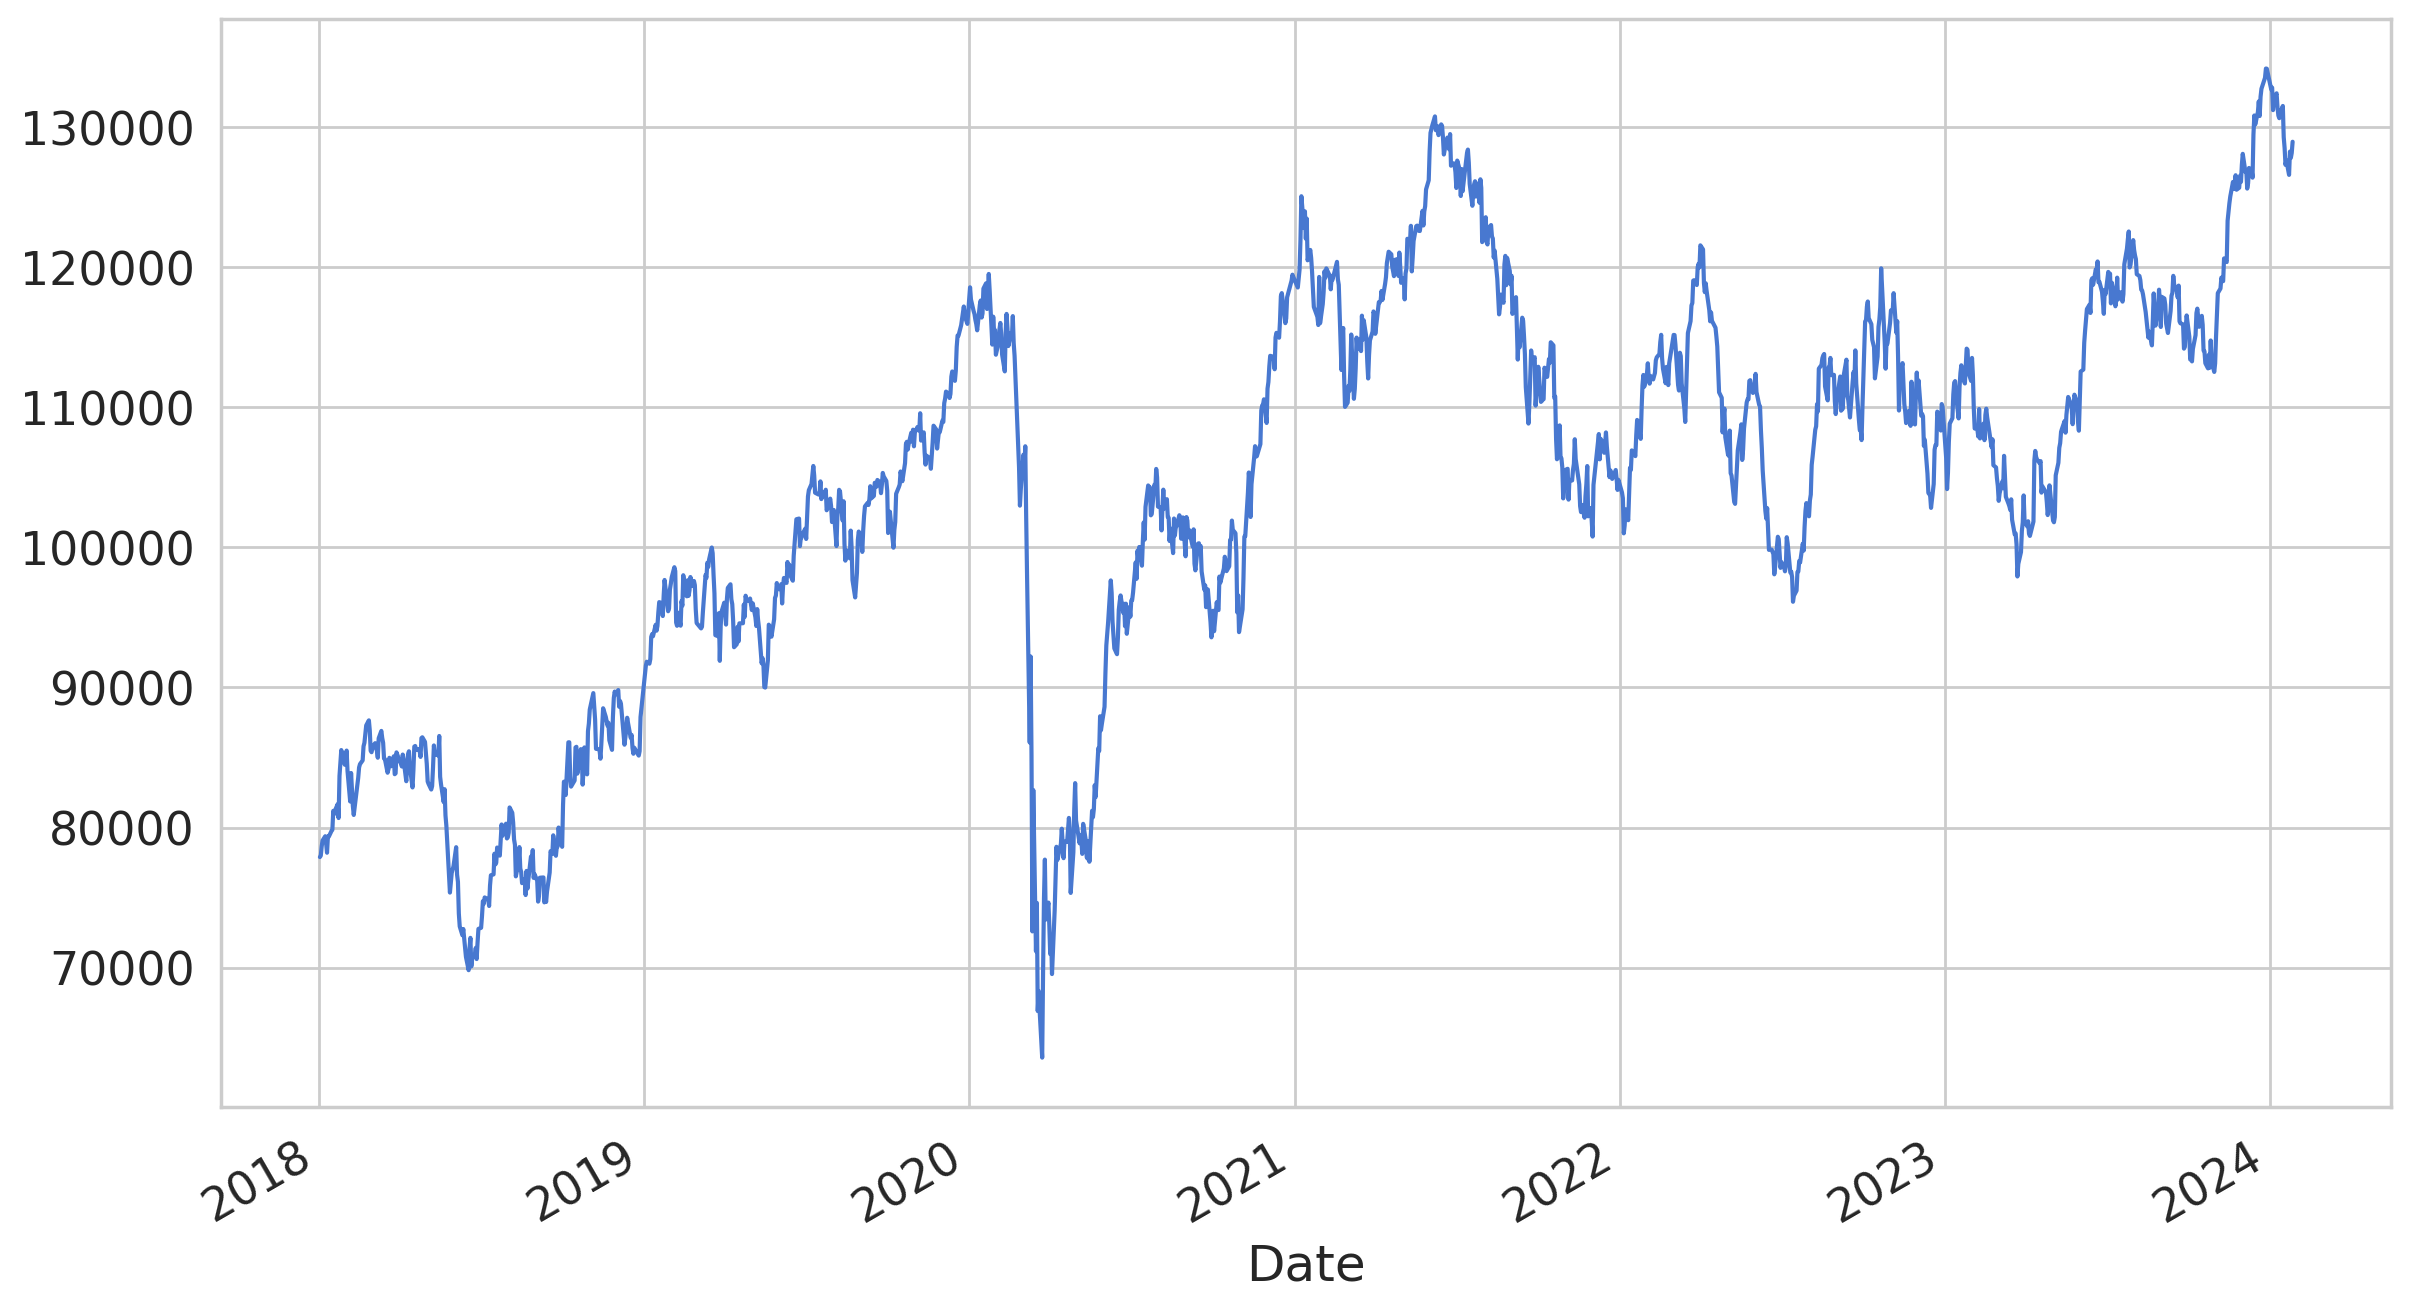

In [6]:
bvsp_full['Adj Close'].plot()

Possível motivo: https://veja.abril.com.br/economia/guerra-comercial-entre-china-e-eua-faz-bolsa-cair-25-e-dolar-subir-17

No grafico acima é possivel visualizar as oscilações da Bolsa de valores em 2018 Guerra Comercial EUA-China. A escalada das tensões comerciais entre os Estados Unidos e a China teve um impacto significativo nos mercados globais, causando volatilidade nas bolsas. Em janeiro de 2019, as negociações comerciais entre os EUA e a China mostraram progresso, aliviando parte da tensão e impulsionando os mercados.
Pandemia de COVID-19: A crise sanitária global começou a afetar os mercados em fevereiro de 2020, levando a quedas acentuadas nas bolsas de valores em todo o mundo.

Possível motivo: https://valorinveste.globo.com/objetivo/hora-de-investir/noticia/2020/03/31/ibovespa-tem-maior-queda-mensal-em-22-anos-dolar-maior-alta-desde-ataque-as-torres-gemeas-em-2011.ghtml
Em 2020 Colapso do Mercado de Ações se inicia em março. A pandemia de COVID-19 levou a uma venda generalizada de ativos, com grandes quedas nos principais índices de ações. Para combater os impactos econômicos da pandemia, bancos centrais ao redor do mundo implementaram políticas de afrouxamento monetário e estímulos econômicos. Após as quedas iniciais, os mercados começaram a se recuperar rapidamente, impulsionados por medidas de estímulo e otimismo em relação ao desenvolvimento de vacinas contra a COVID-19.
Os mercados continuaram a se recuperar em 2021, à medida que a vacinação contra a COVID-19 avançava e as perspectivas econômicas melhoravam.

Possível motivo: https://valorinveste.globo.com/mercados/renda-variavel/bolsas-e-indices/noticia/2022/12/31/retrospectiva-da-bolsa-em-2022-veja-mes-a-mes-o-sobe-e-desce-que-rendeu-5percent.ghtml
Em 2022 foi um ano de altos e baixos. De acordo com o Valor Investe, o Ibovespa teve um crescimento de 5% no ano, apesar de ter passado por uma queda de 19% em junho de 2022.

Preocupações com a inflação e as mudanças nas políticas monetárias dos bancos centrais influenciaram a volatilidade em alguns momentos.
Empresas de tecnologia continuaram a desempenhar um papel importante nas oscilações do mercado, com investidores atentos a notícias e eventos relacionados a essas empresas.

In [7]:
# analisar apenas 2022 em diante

df = bvsp_full.loc[(bvsp_full.index >= '2023-01-01') & (bvsp_full.index < '2024-01-12')]

<Axes: xlabel='Date'>

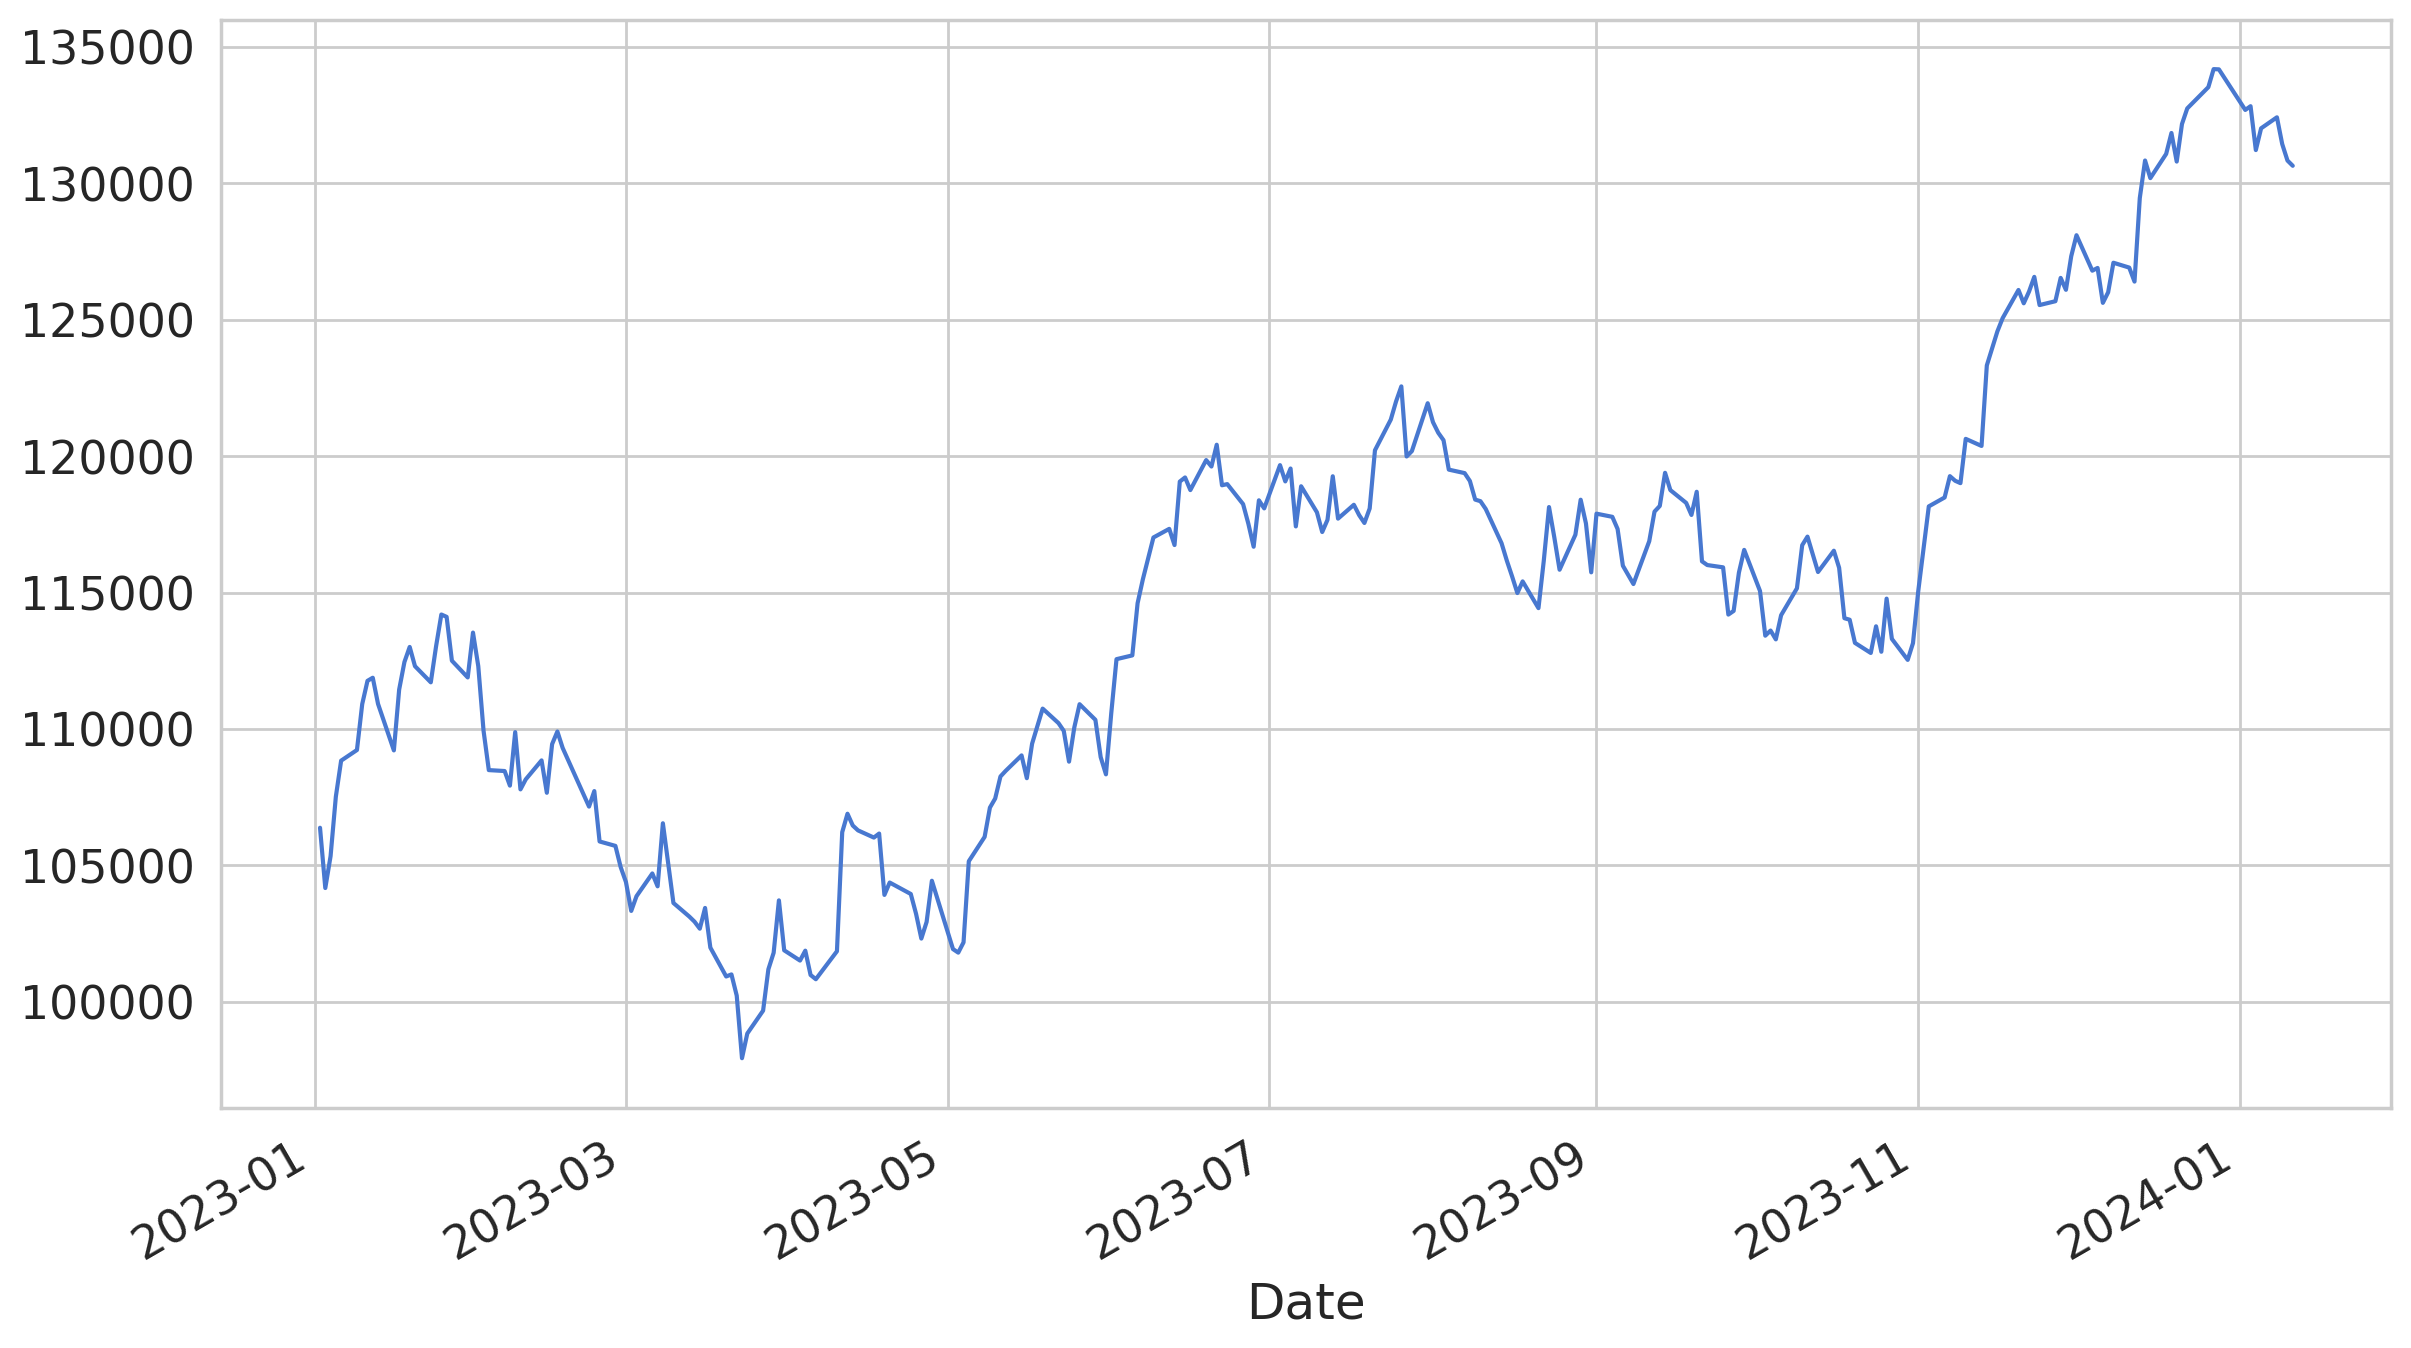

In [8]:
df['Adj Close'].plot()

In [9]:
# analisando período jan-2023 até jan-2024

import yfinance as yf

symbol = '^BVSP'
start_date = '2023-01-01'
end_date = '2024-01-16'

df = yf.download(symbol, start=start_date, end=end_date)

csv_filename = 'dadosBolsa.csv'
df.to_csv(csv_filename)

import pandas as pd

df = pd.read_csv("dadosBolsa.csv", sep=",")

import seaborn as sns
import matplotlib.pyplot as plt

df_limpo = df                                                              # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        # transformando em datetime
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Close'])     # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')                                      # definindo data como índice

[*********************100%%**********************]  1 of 1 completed


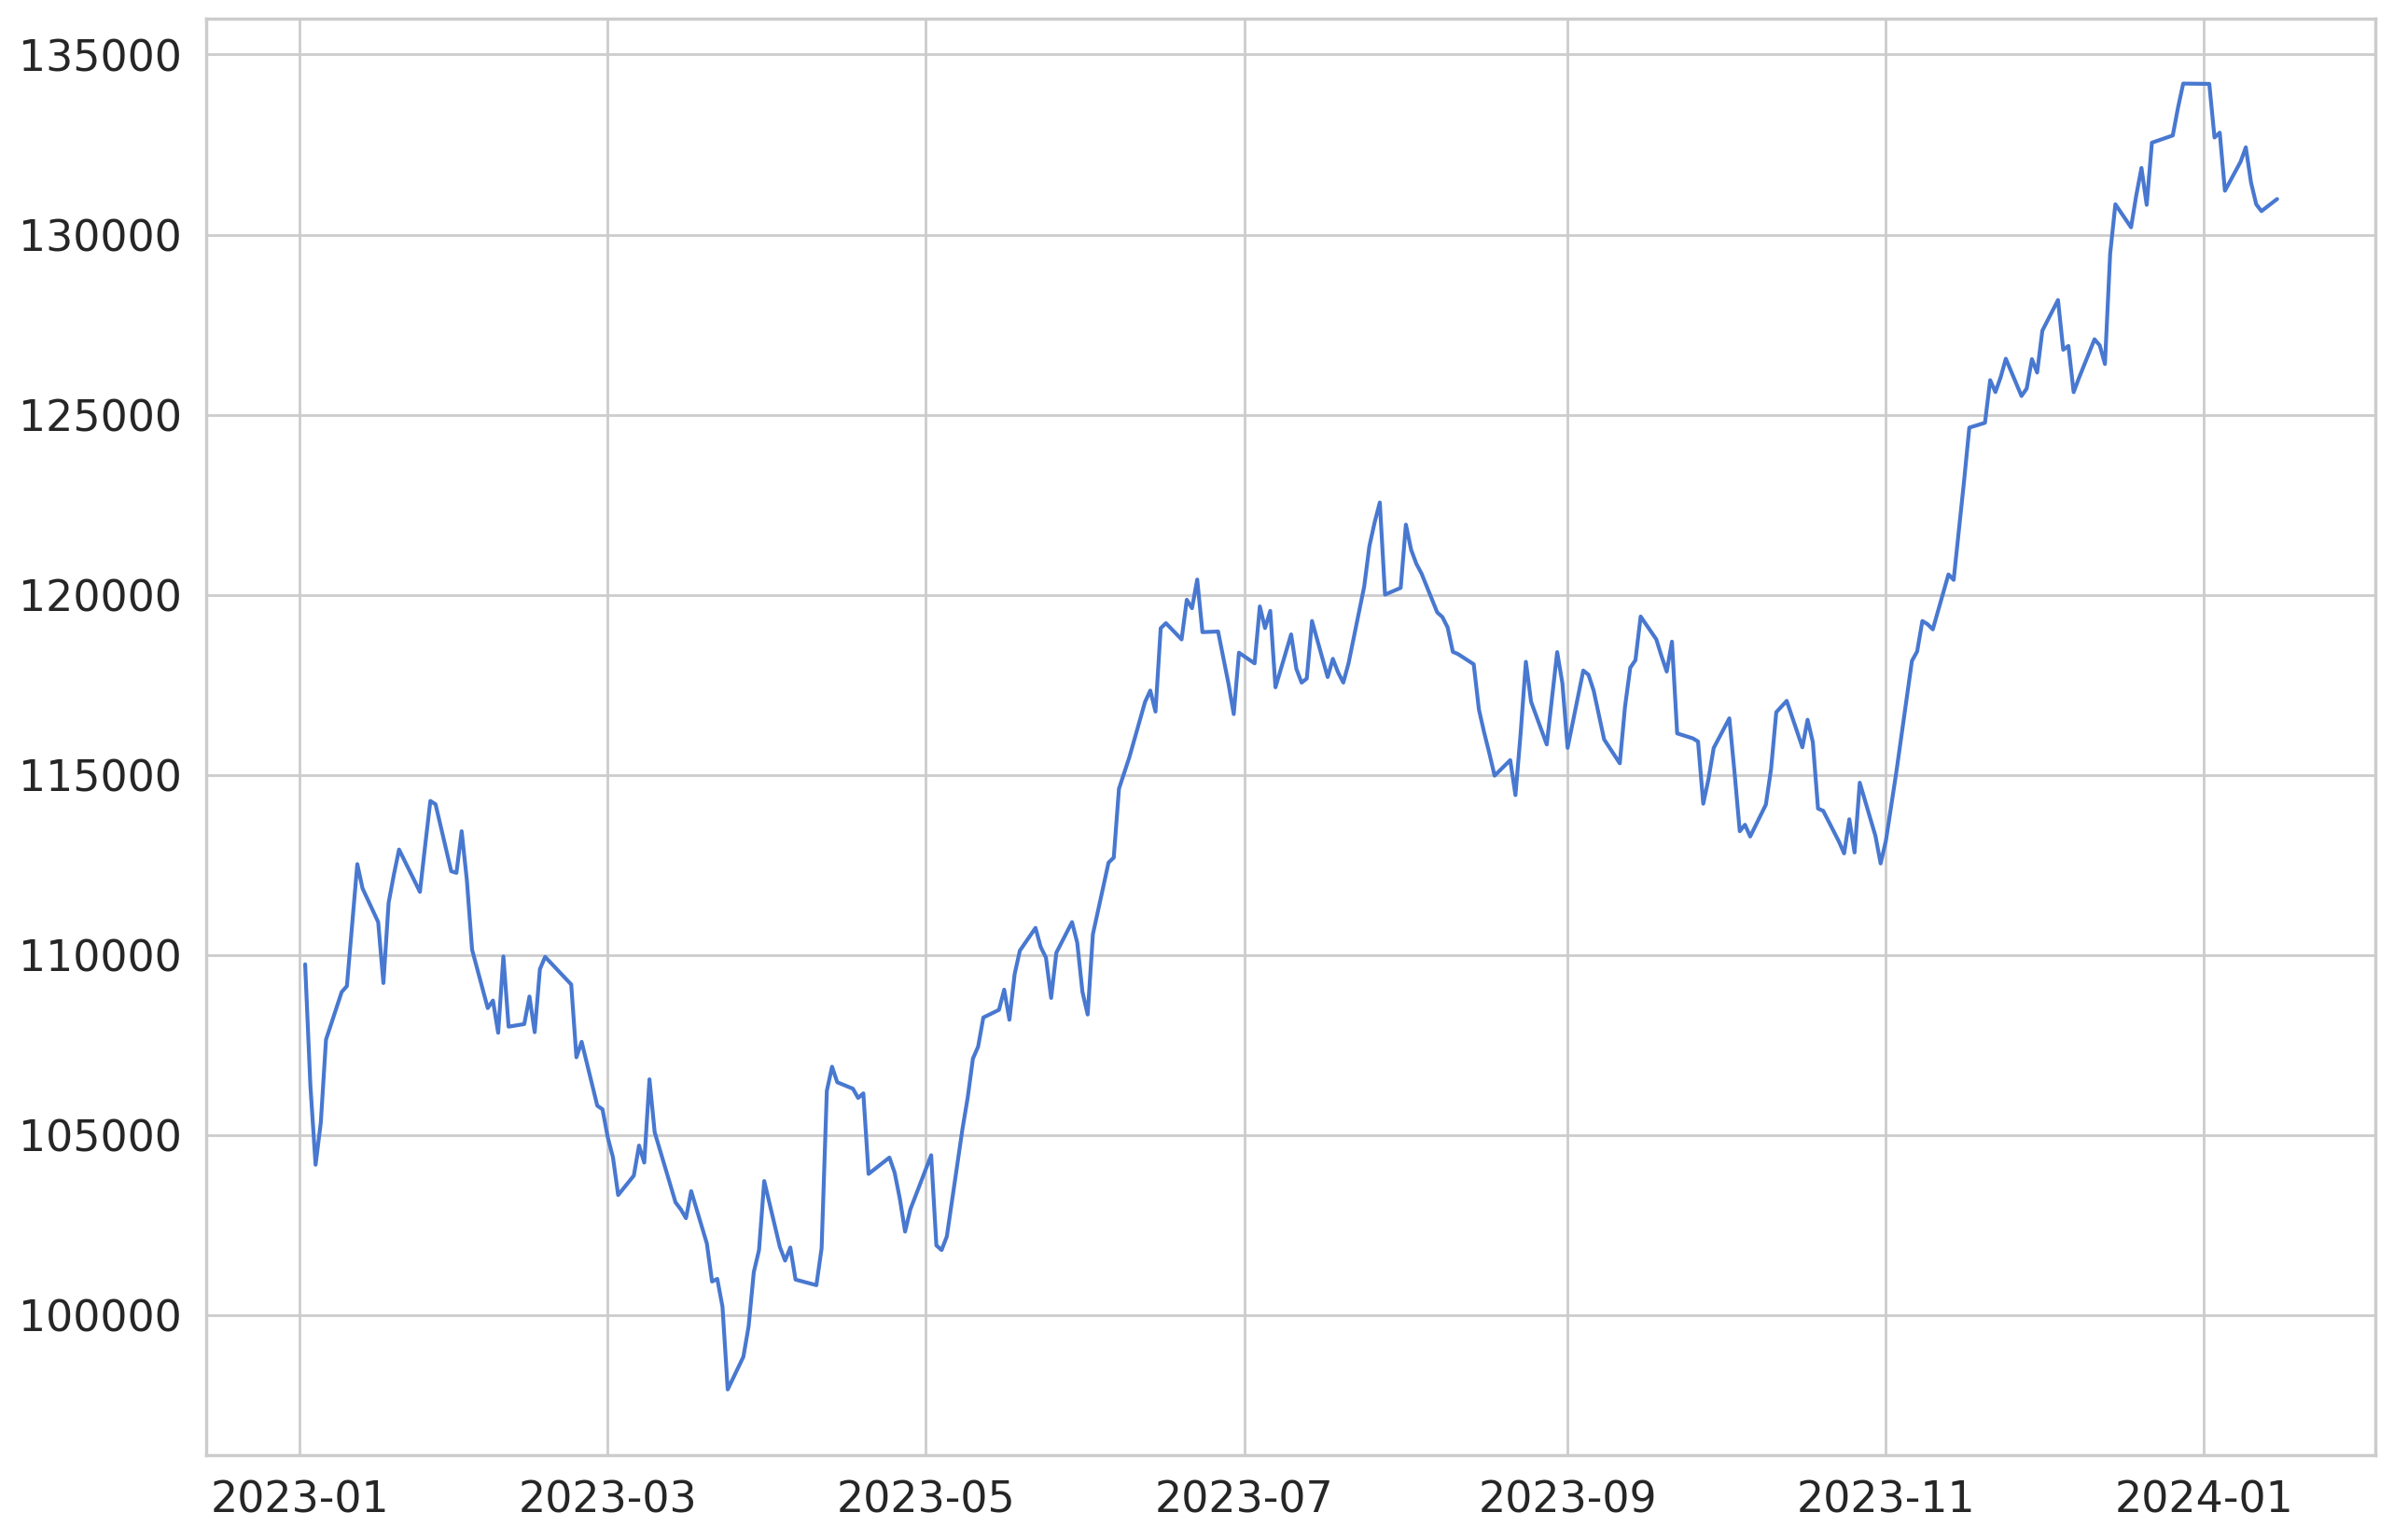

In [10]:
# Relação Date x Open

plt.figure(figsize = (15,10))
plt.plot(df['Date'], df['Open'], label='BVSP')

plt.show()

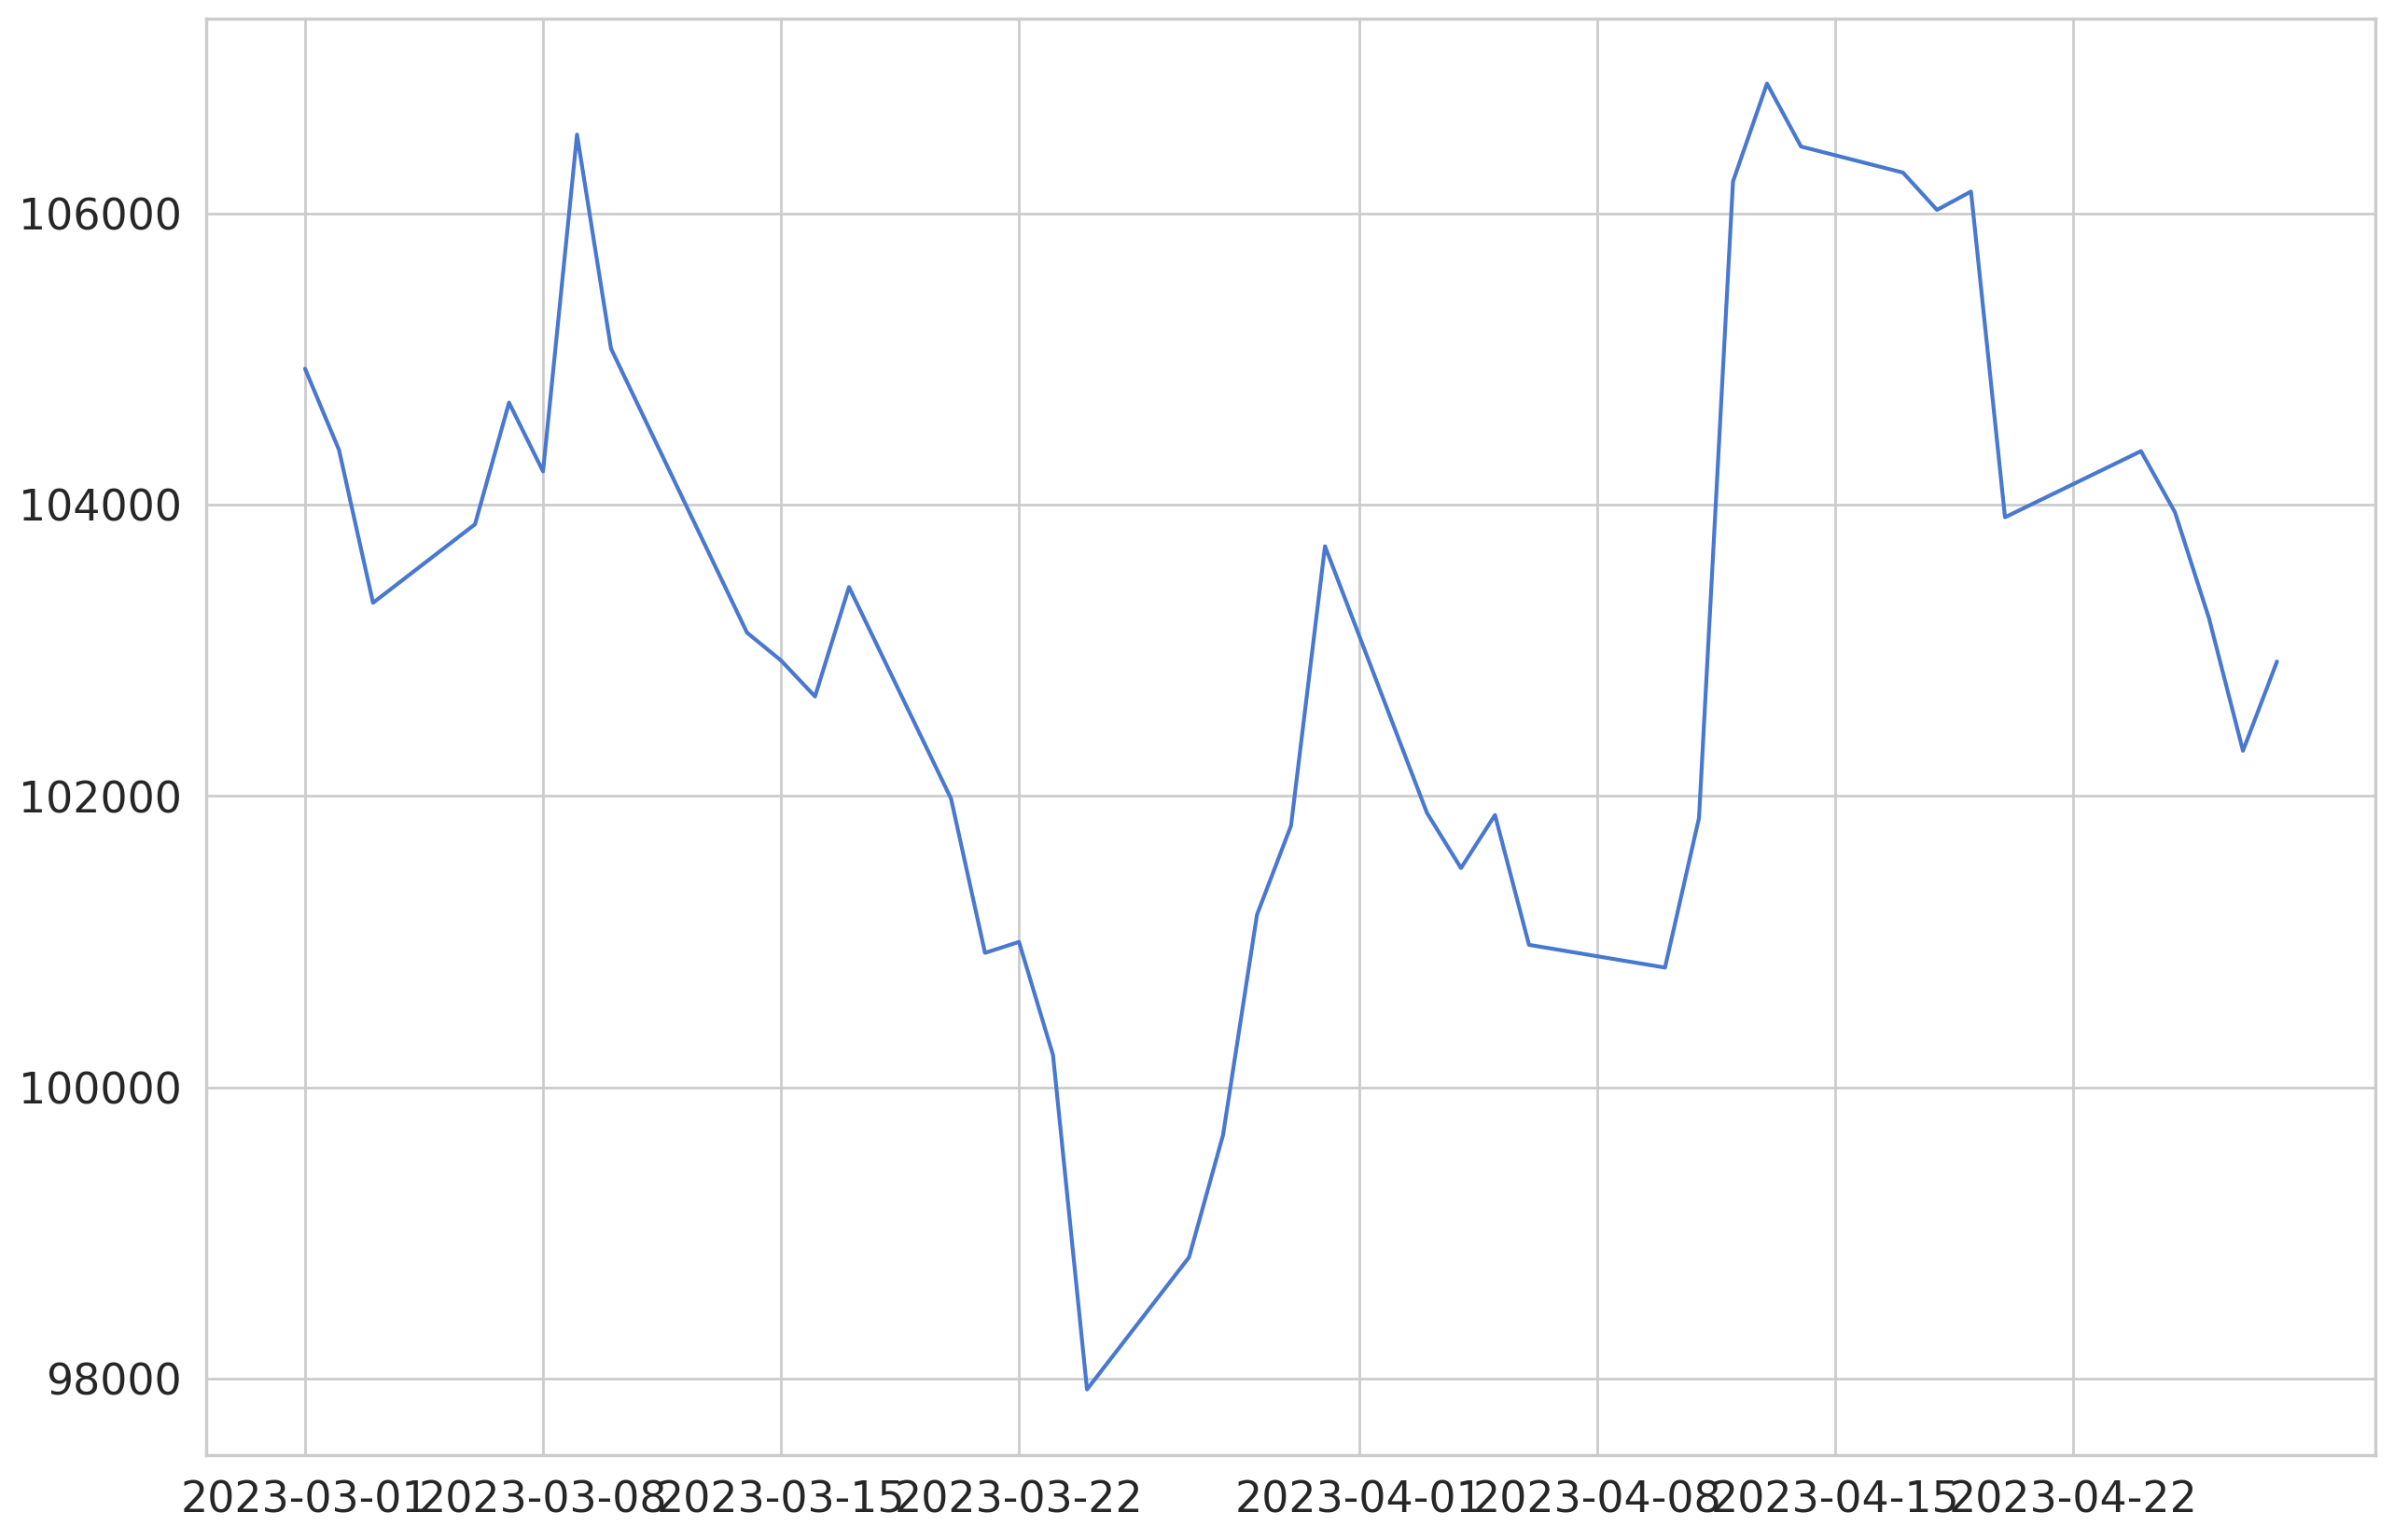

In [11]:
# Detalhando períodos de queda aparente

# Maior pico de queda aparente aconnteceu entre 2023-03 e 2023-05

periodo1 = (df['Date'] >= '2023-03-01') & (df['Date'] <= '2023-05-01')

df_periodo1 = df[periodo1]

plt.figure(figsize = (15,10))
plt.plot(df_periodo1['Date'], df_periodo1['Open'], label='BVSP')

plt.show()

Possível motivo: https://exame.com/invest/mercados/ibovespa-hoje-31-03-2023/

Analisando o primeiro trimestre de 2023, podemos ver que janeiro começou de forma positiva subindo 3,4%, apoiado principalmente nas ações das commodities com a reabertura econômica da China.

Em fevereiro, olhando para a situação macroeconômica percebemos um "aperto". Aqui internamente, debates entre o presidente do Brasil e o Banco Central continuou trazendo volatilidade. Nos Estados Unidos, fortes inflamções aumentaram o receio de um aperto monetário mais duro. O Ibovespa caiu 7,5% no mês, seu pior resultado mensal desde junho de 2022.

Em março, ainda com a volatilidade acontecendo, uns dos principais motivos que ajudaram nesta queda foi a crise bancária deflagrada pelo americano SVB tomou as manchetes e acendeu um alerta sobre os efeitos da trajetória de alta dos juros.

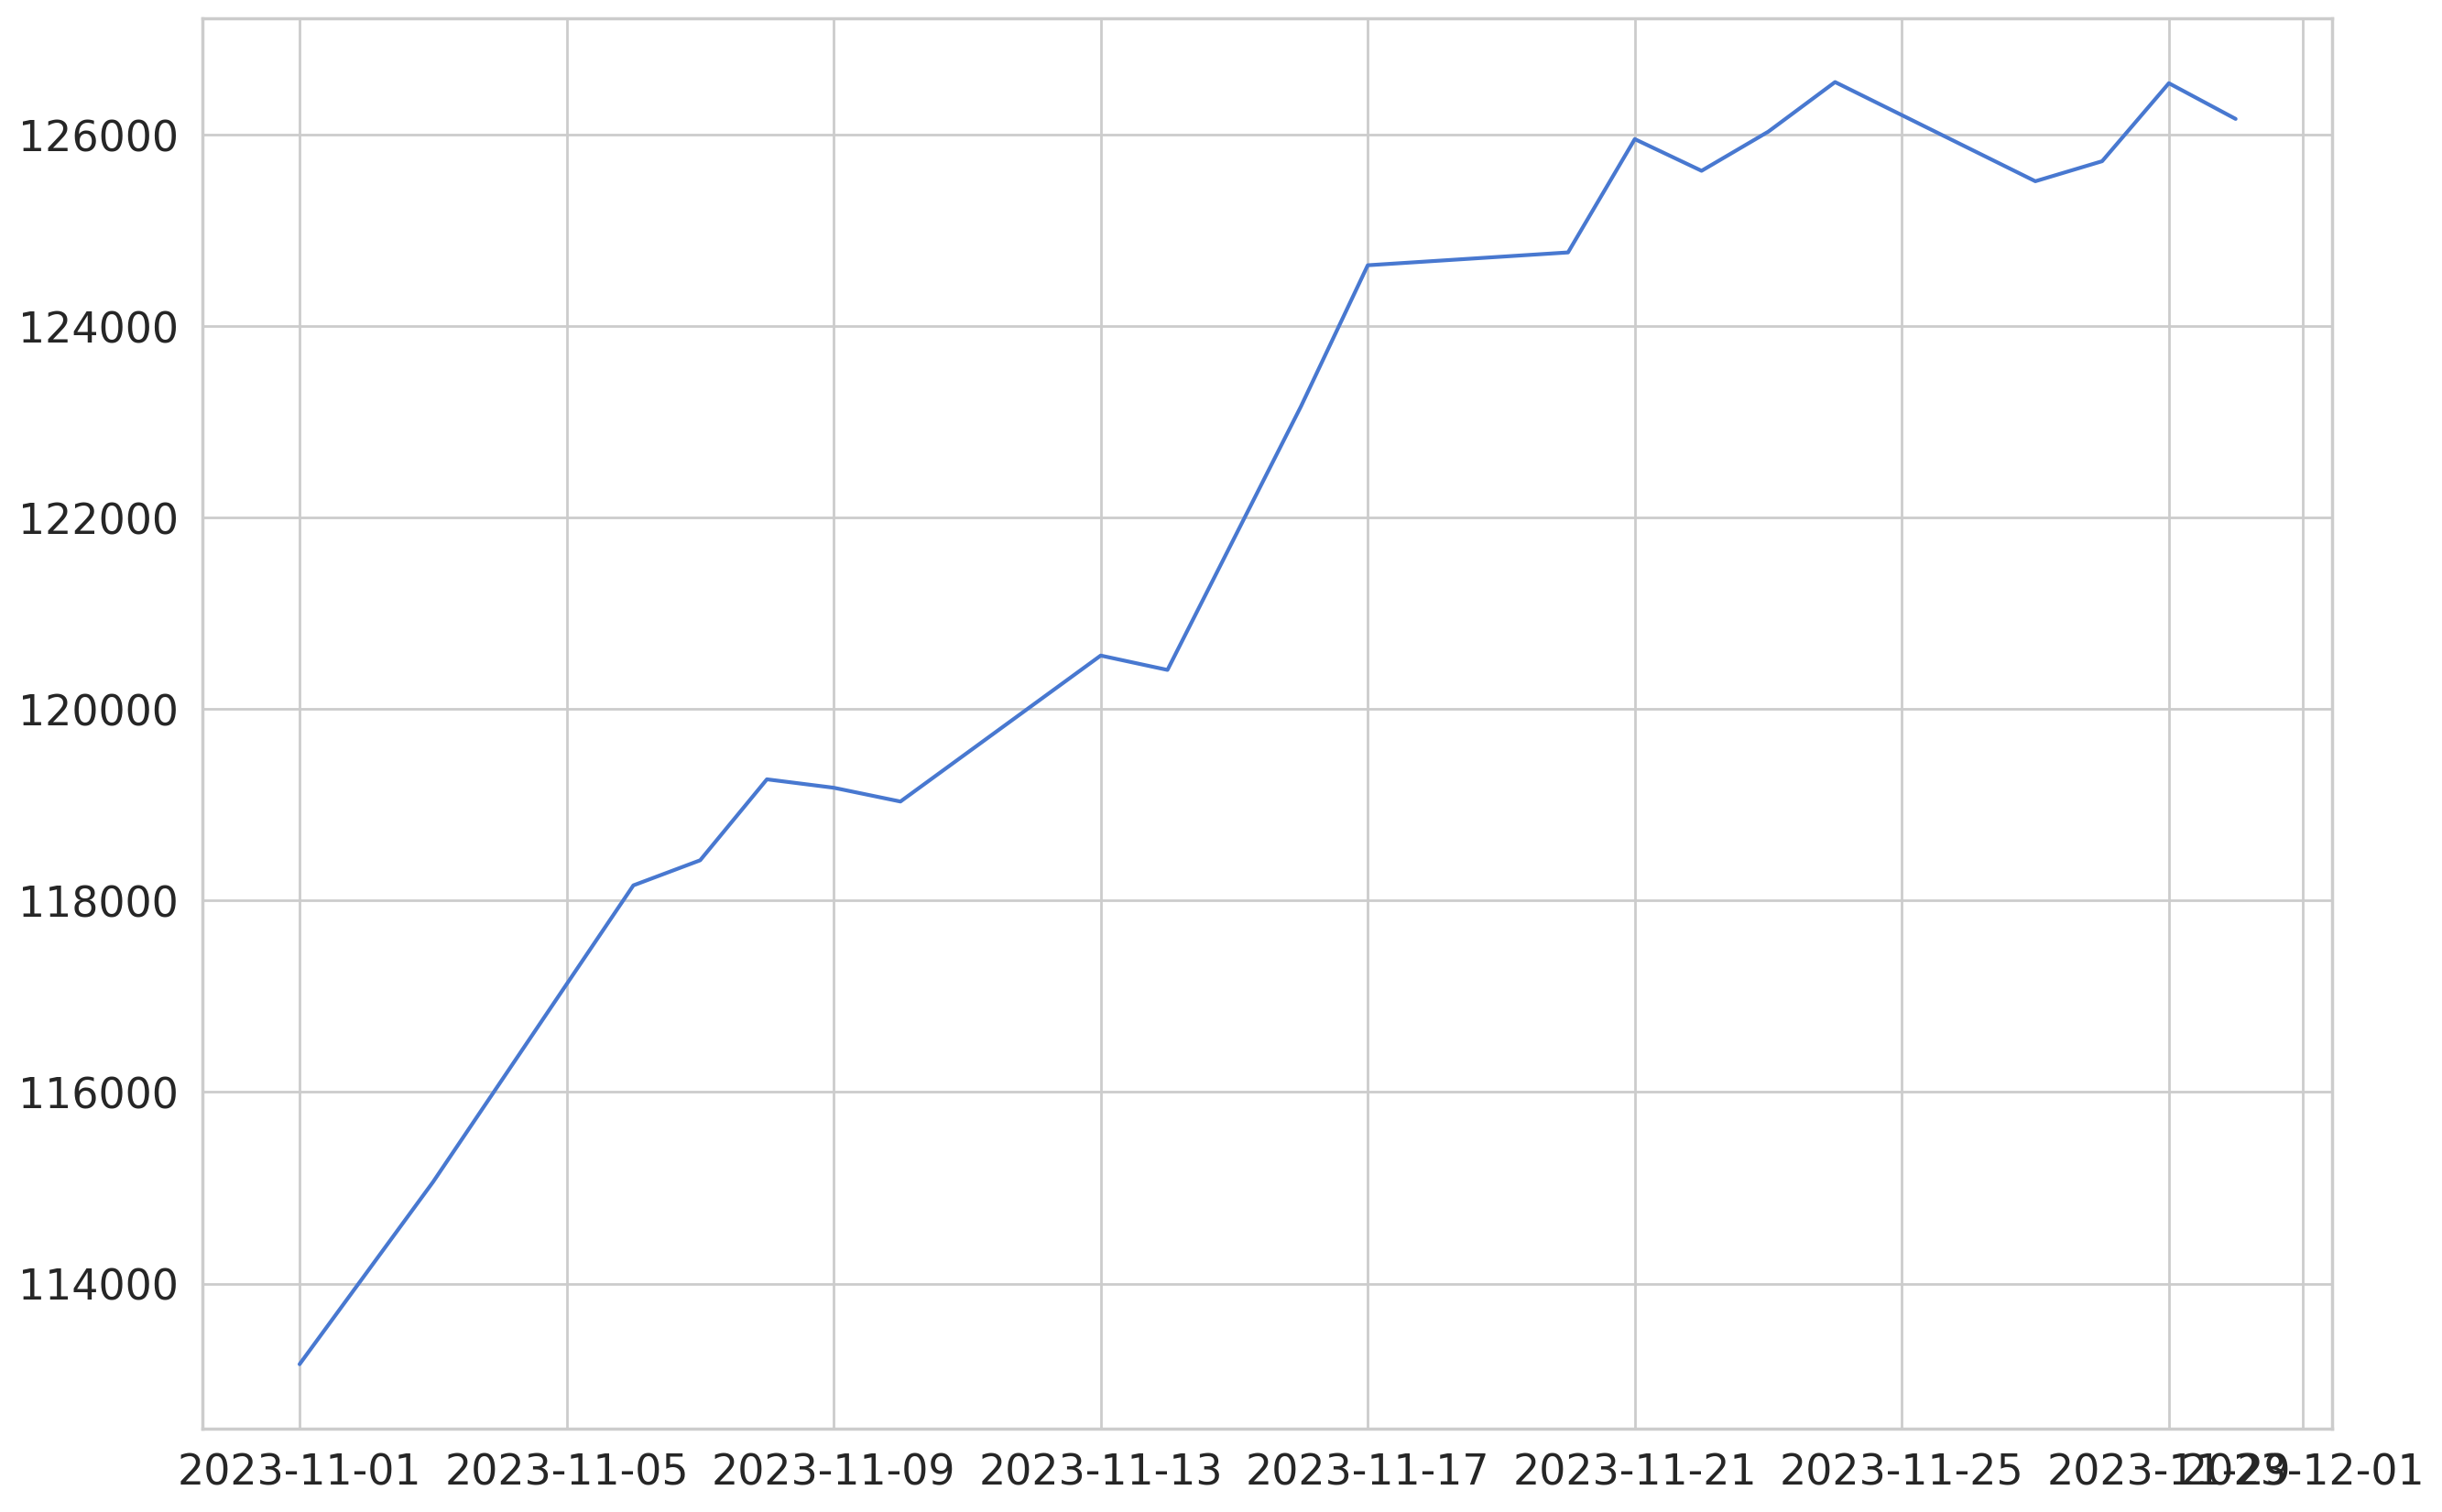

In [12]:
# Detalhando período de alta aparente

# Maior crescimento aparente parece ter acontecido entre 2023-11 e entrando em 2024-01

periodo2 = (df['Date'] >= '2023-11-01') & (df['Date'] <= '2023-11-30')

df_periodo2 = df[periodo2]

plt.figure(figsize = (15,10))
plt.plot(df_periodo2['Date'], df_periodo2['Open'], label='BVSP')

plt.show()

Possível motivo: https://einvestidor.estadao.com.br/mercado/ibovespa-alta-novembro-2023/ - https://www.cnnbrasil.com.br/economia/mercados-hoje-30-de-novembro-de-2023/

Em novembro de 2023 vimos uma alta mensal de 12,54%, o que não acontecia desde 2020. Olhando principalmente para o cenário interno, a questão fiscal voltou a ficar em evidência e com indicativos mais positivos Em novembro, o governo sinalizou que deve manter a meta de déficit fiscal zero no Projeto de Lei de Diretrizes Orçamentárias (PLDO) de 2024.

Também houve o que podemos chamar de alta generalizada, o que envolve acontecimentos externos, por exemplo, o ciclo de alta de juros nos EUA que também influenciou de forma positiva a bolsa.

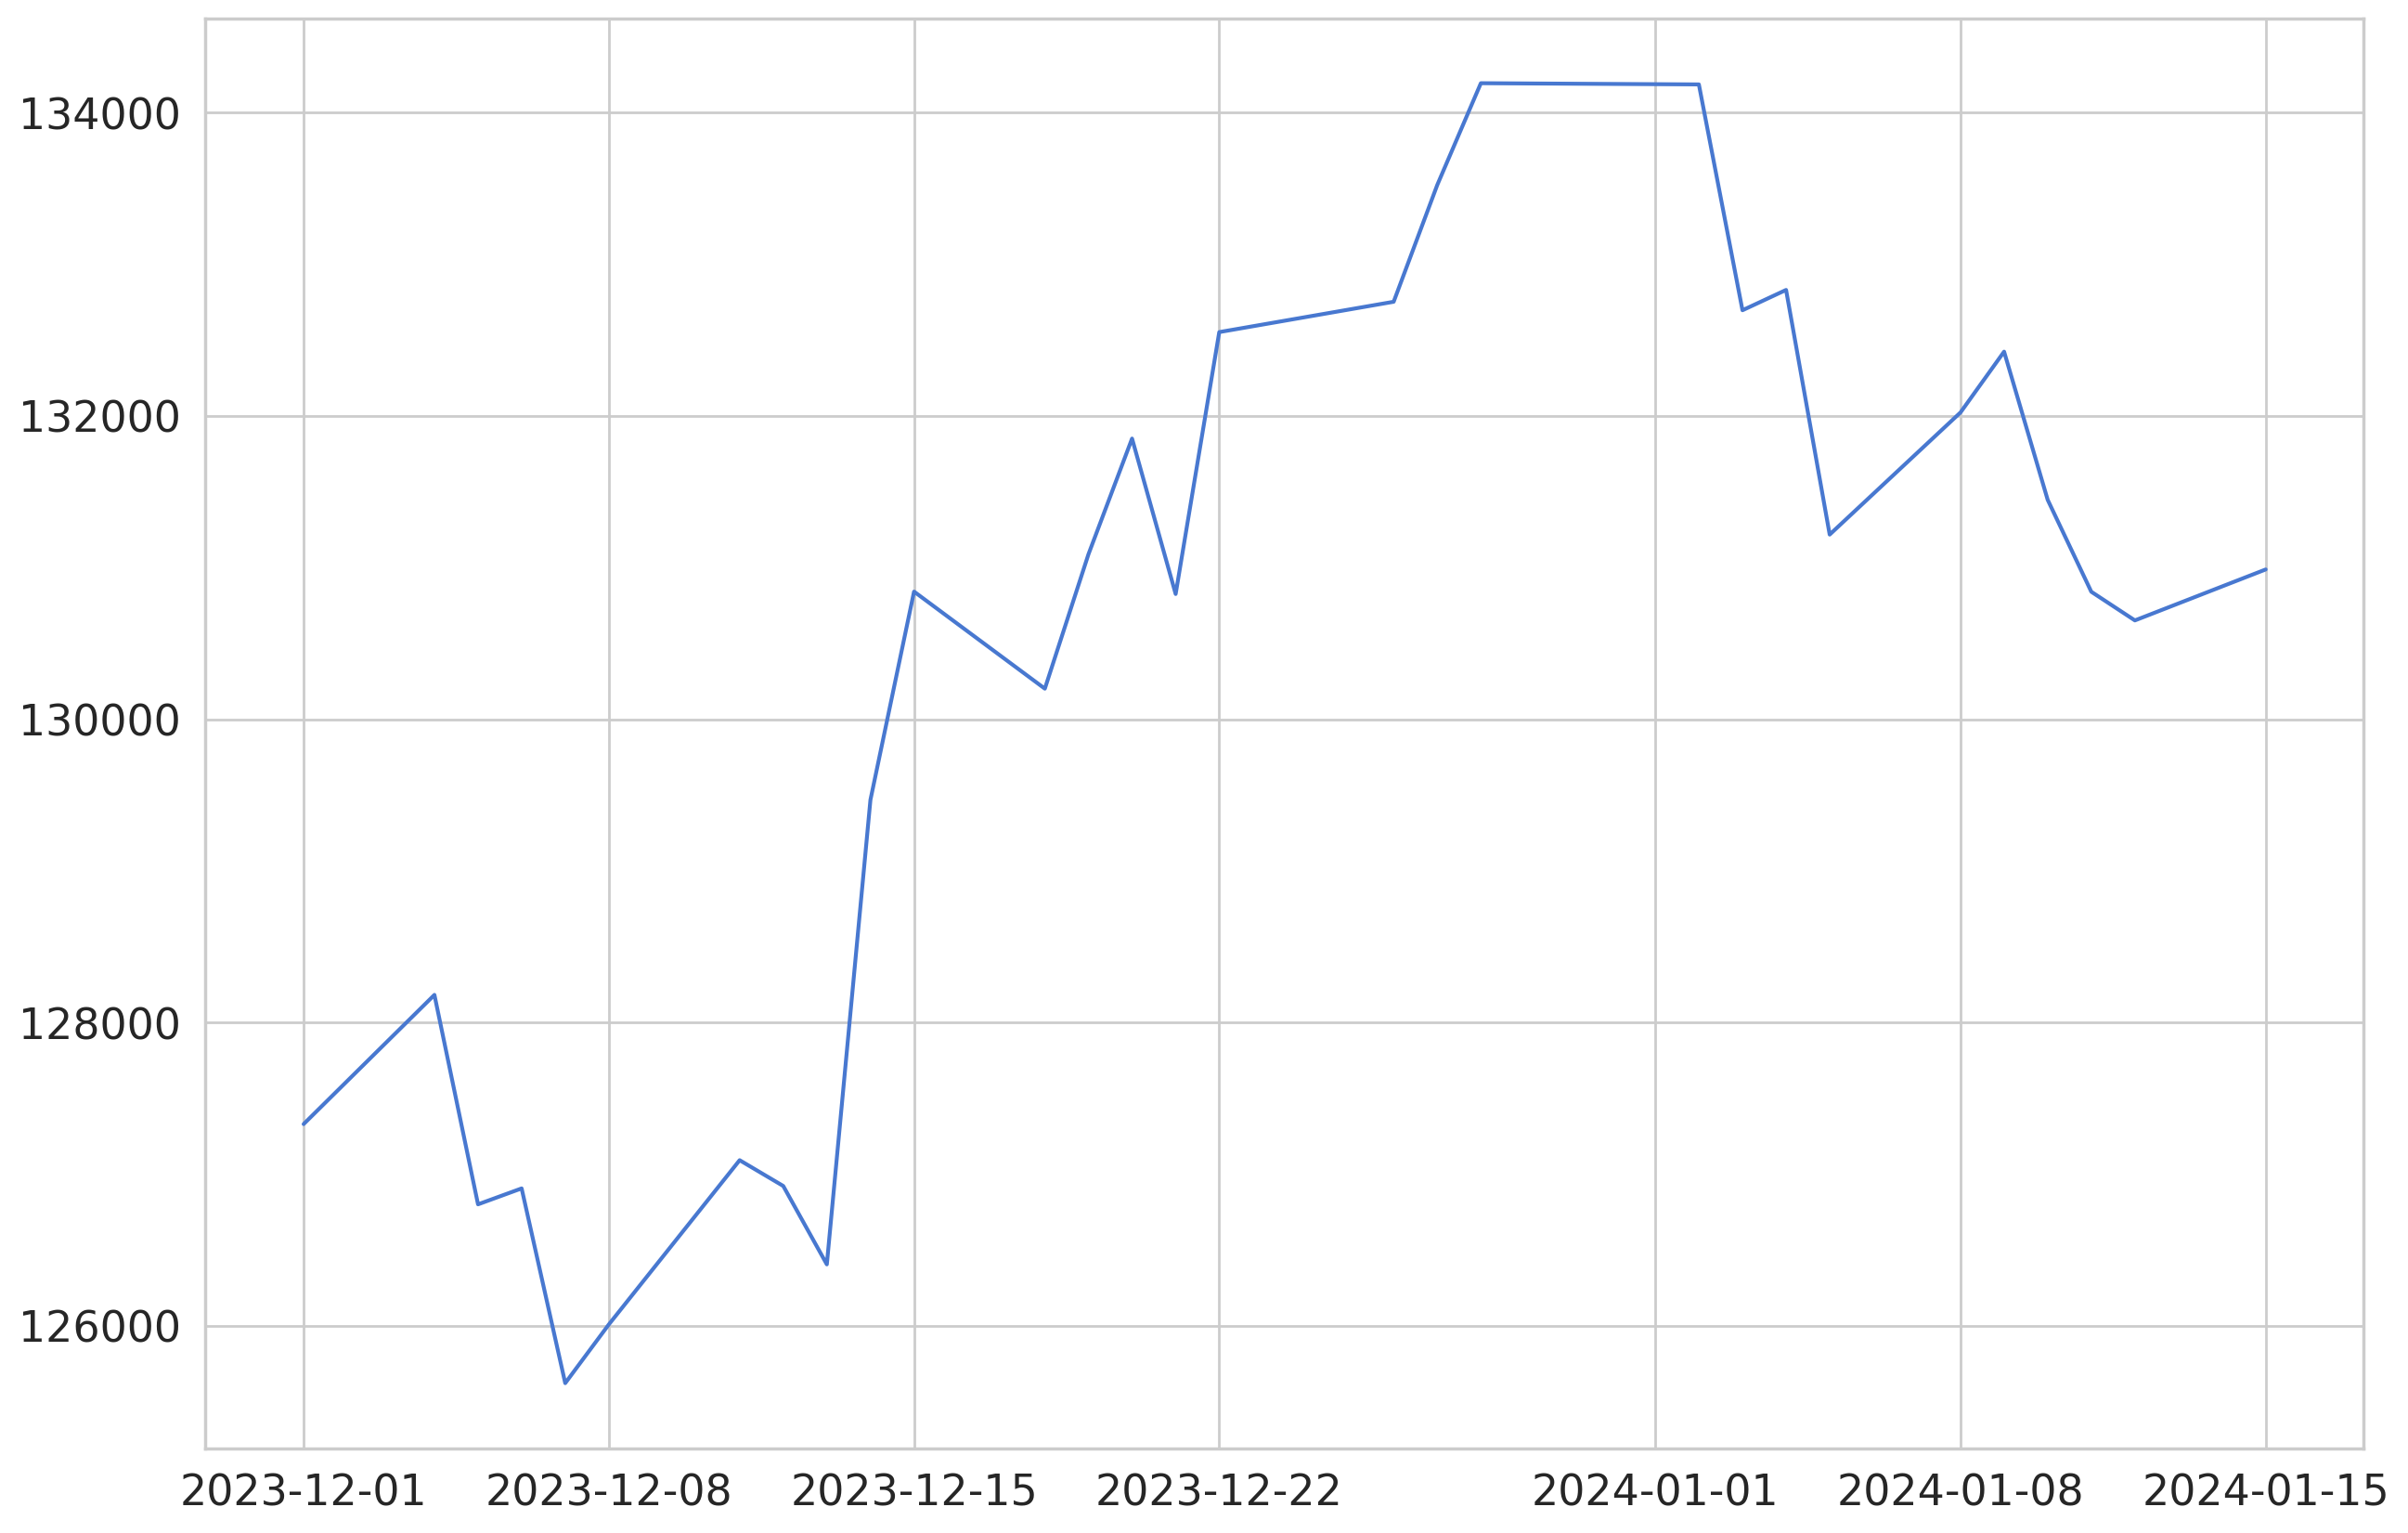

In [13]:
# Detalhando aumento em 2024-01

periodo3 = (df['Date'] >= '2023-12-01') & (df['Date'] <= '2024-01-16')

df_periodo3 = df[periodo3]

plt.figure(figsize = (15,10))
plt.plot(df_periodo3['Date'], df_periodo3['Open'], label='BVSP')

plt.show()

Possível motivo: https://einvestidor.estadao.com.br/mercado/o-que-esperar-ibovespa-janeiro-2024/

O que justificaria este crescimento, seria o que vimos nas últimas análises a perspectiva de fim do ciclo de alta de juros nos Estados Unidos e a melhora do cenário macro no Brasil, permanecem no radar. Sem novos fatores, esses eventos devem manter o a tendência positiva no mercado.

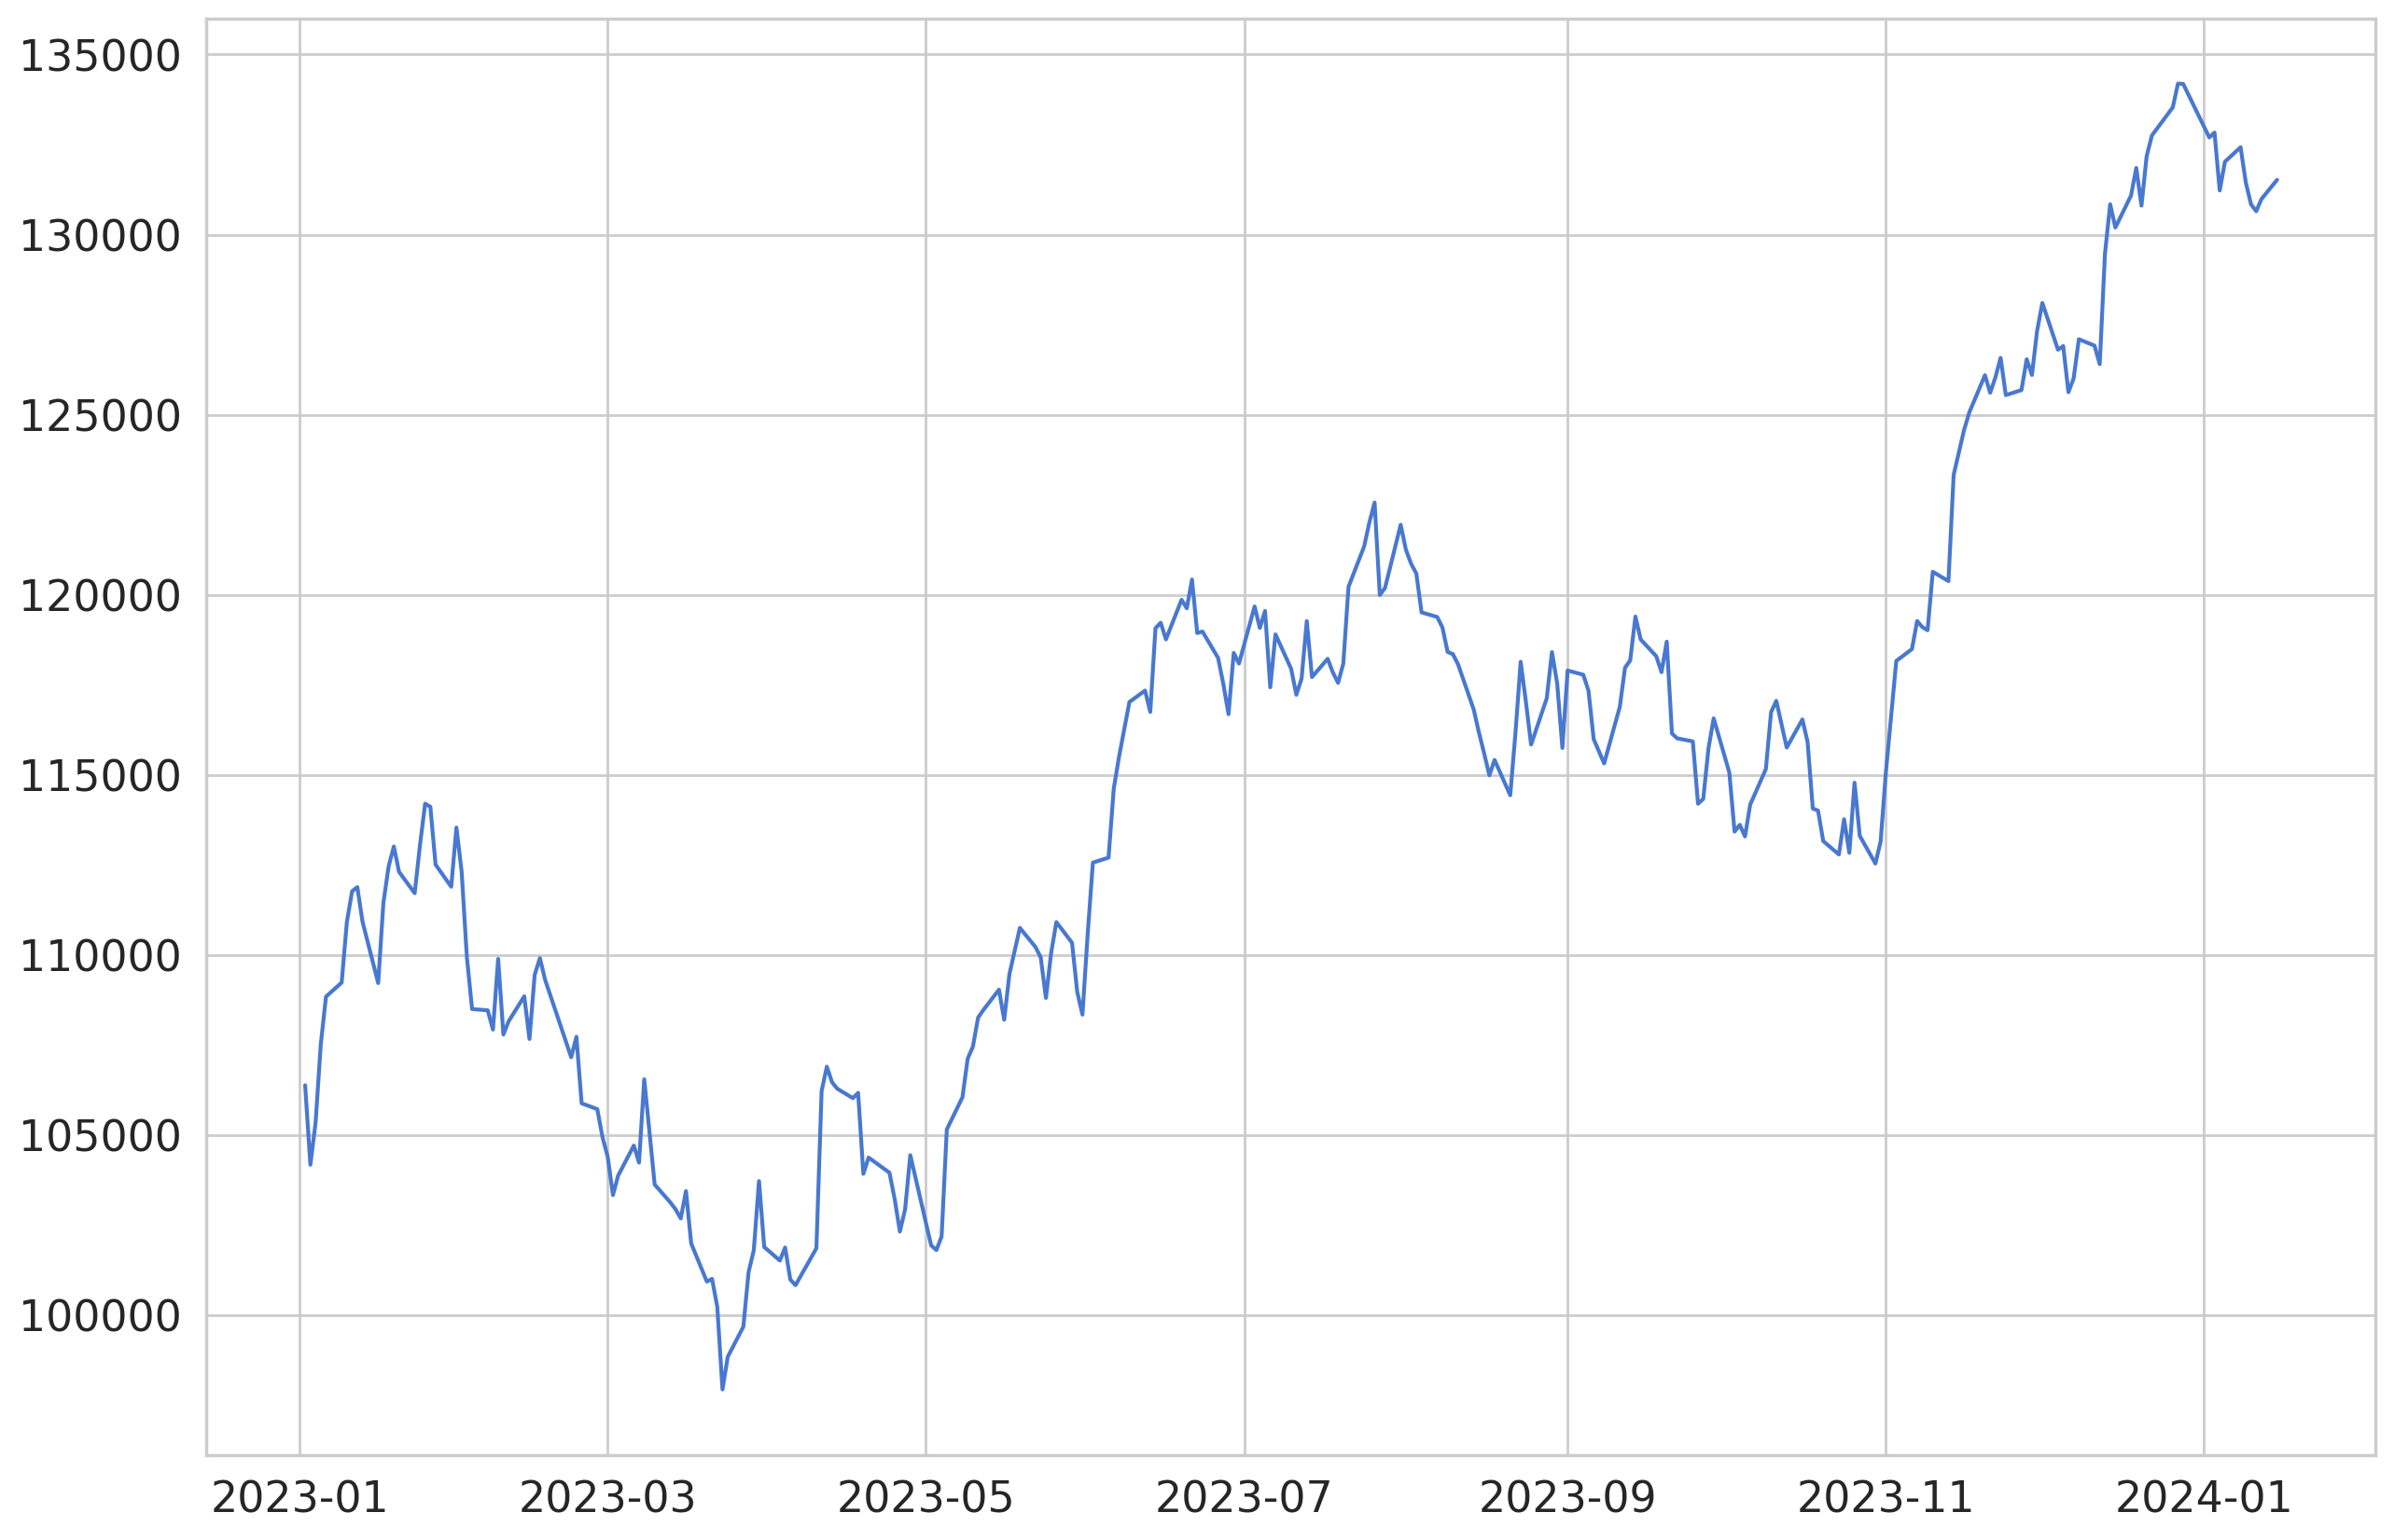

In [14]:
# Relação Date x Adj Close (selecionar um período)

plt.figure(figsize = (15,10))
plt.plot(df['Date'],df['Adj Close'], label='BVSP')

plt.show()

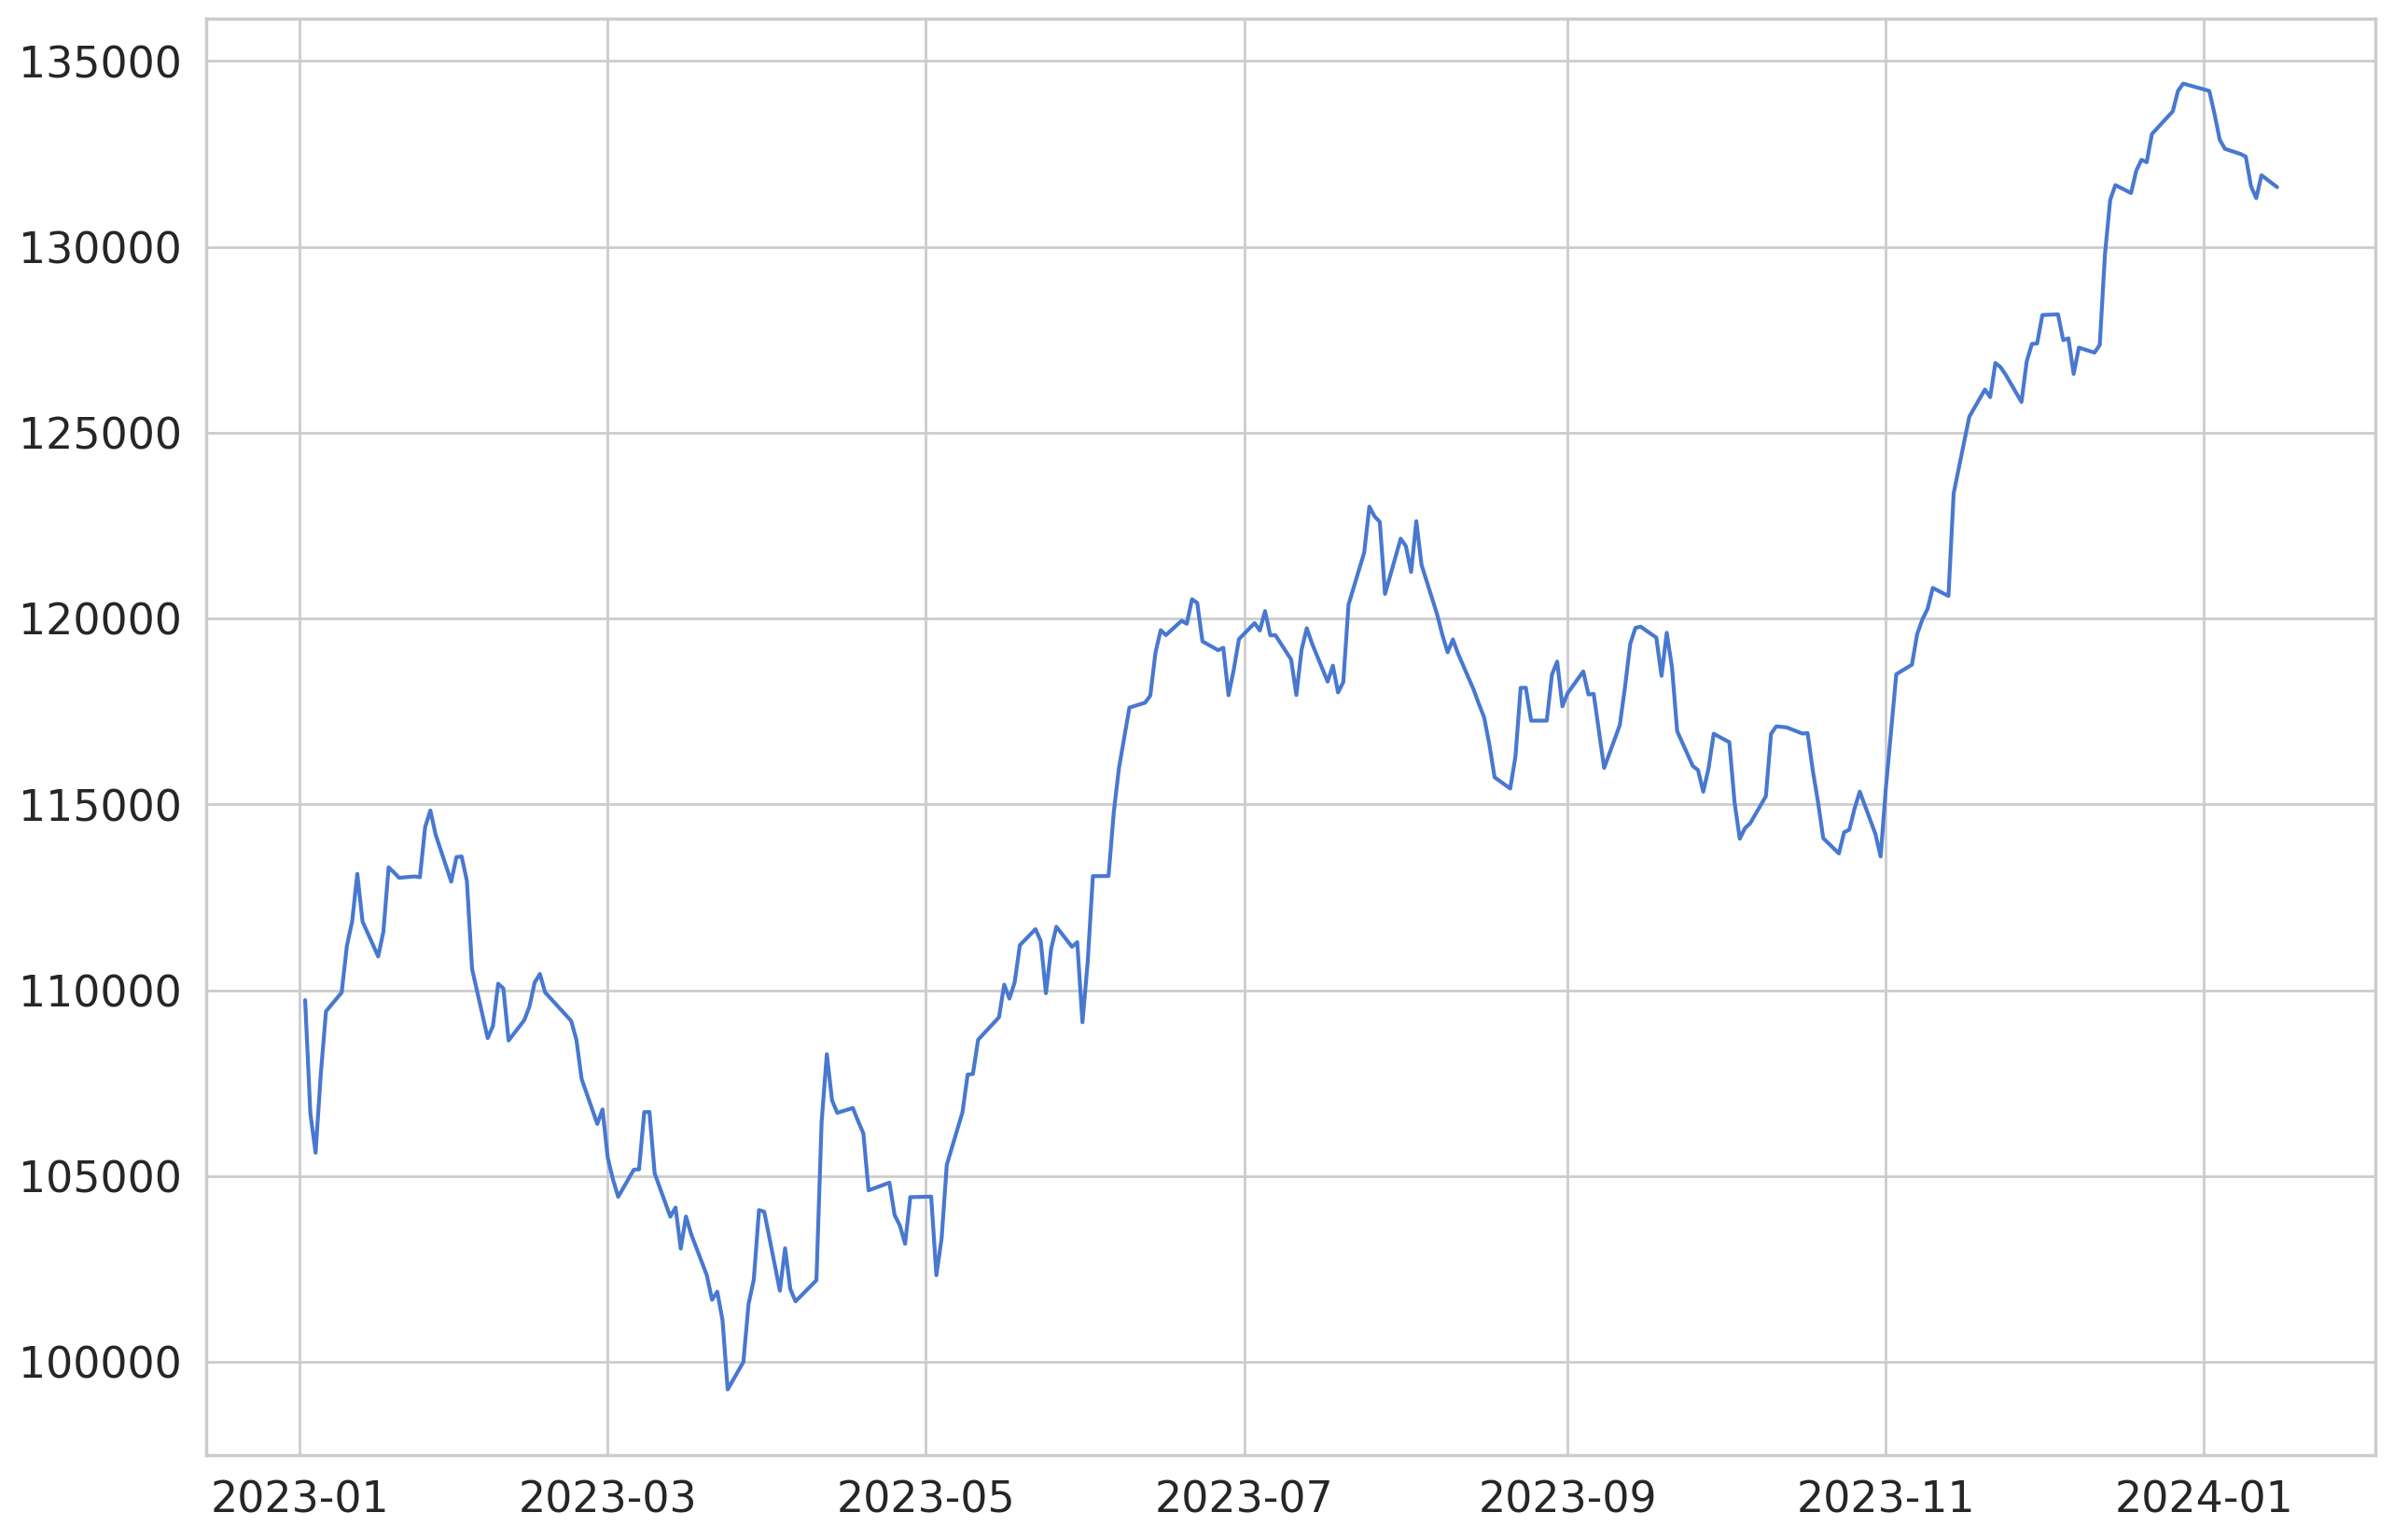

In [15]:
# Relação Date x High (selecionar um período)

plt.figure(figsize = (15,10))
plt.plot(df['Date'], df['High'], label='BVSP')

plt.show()

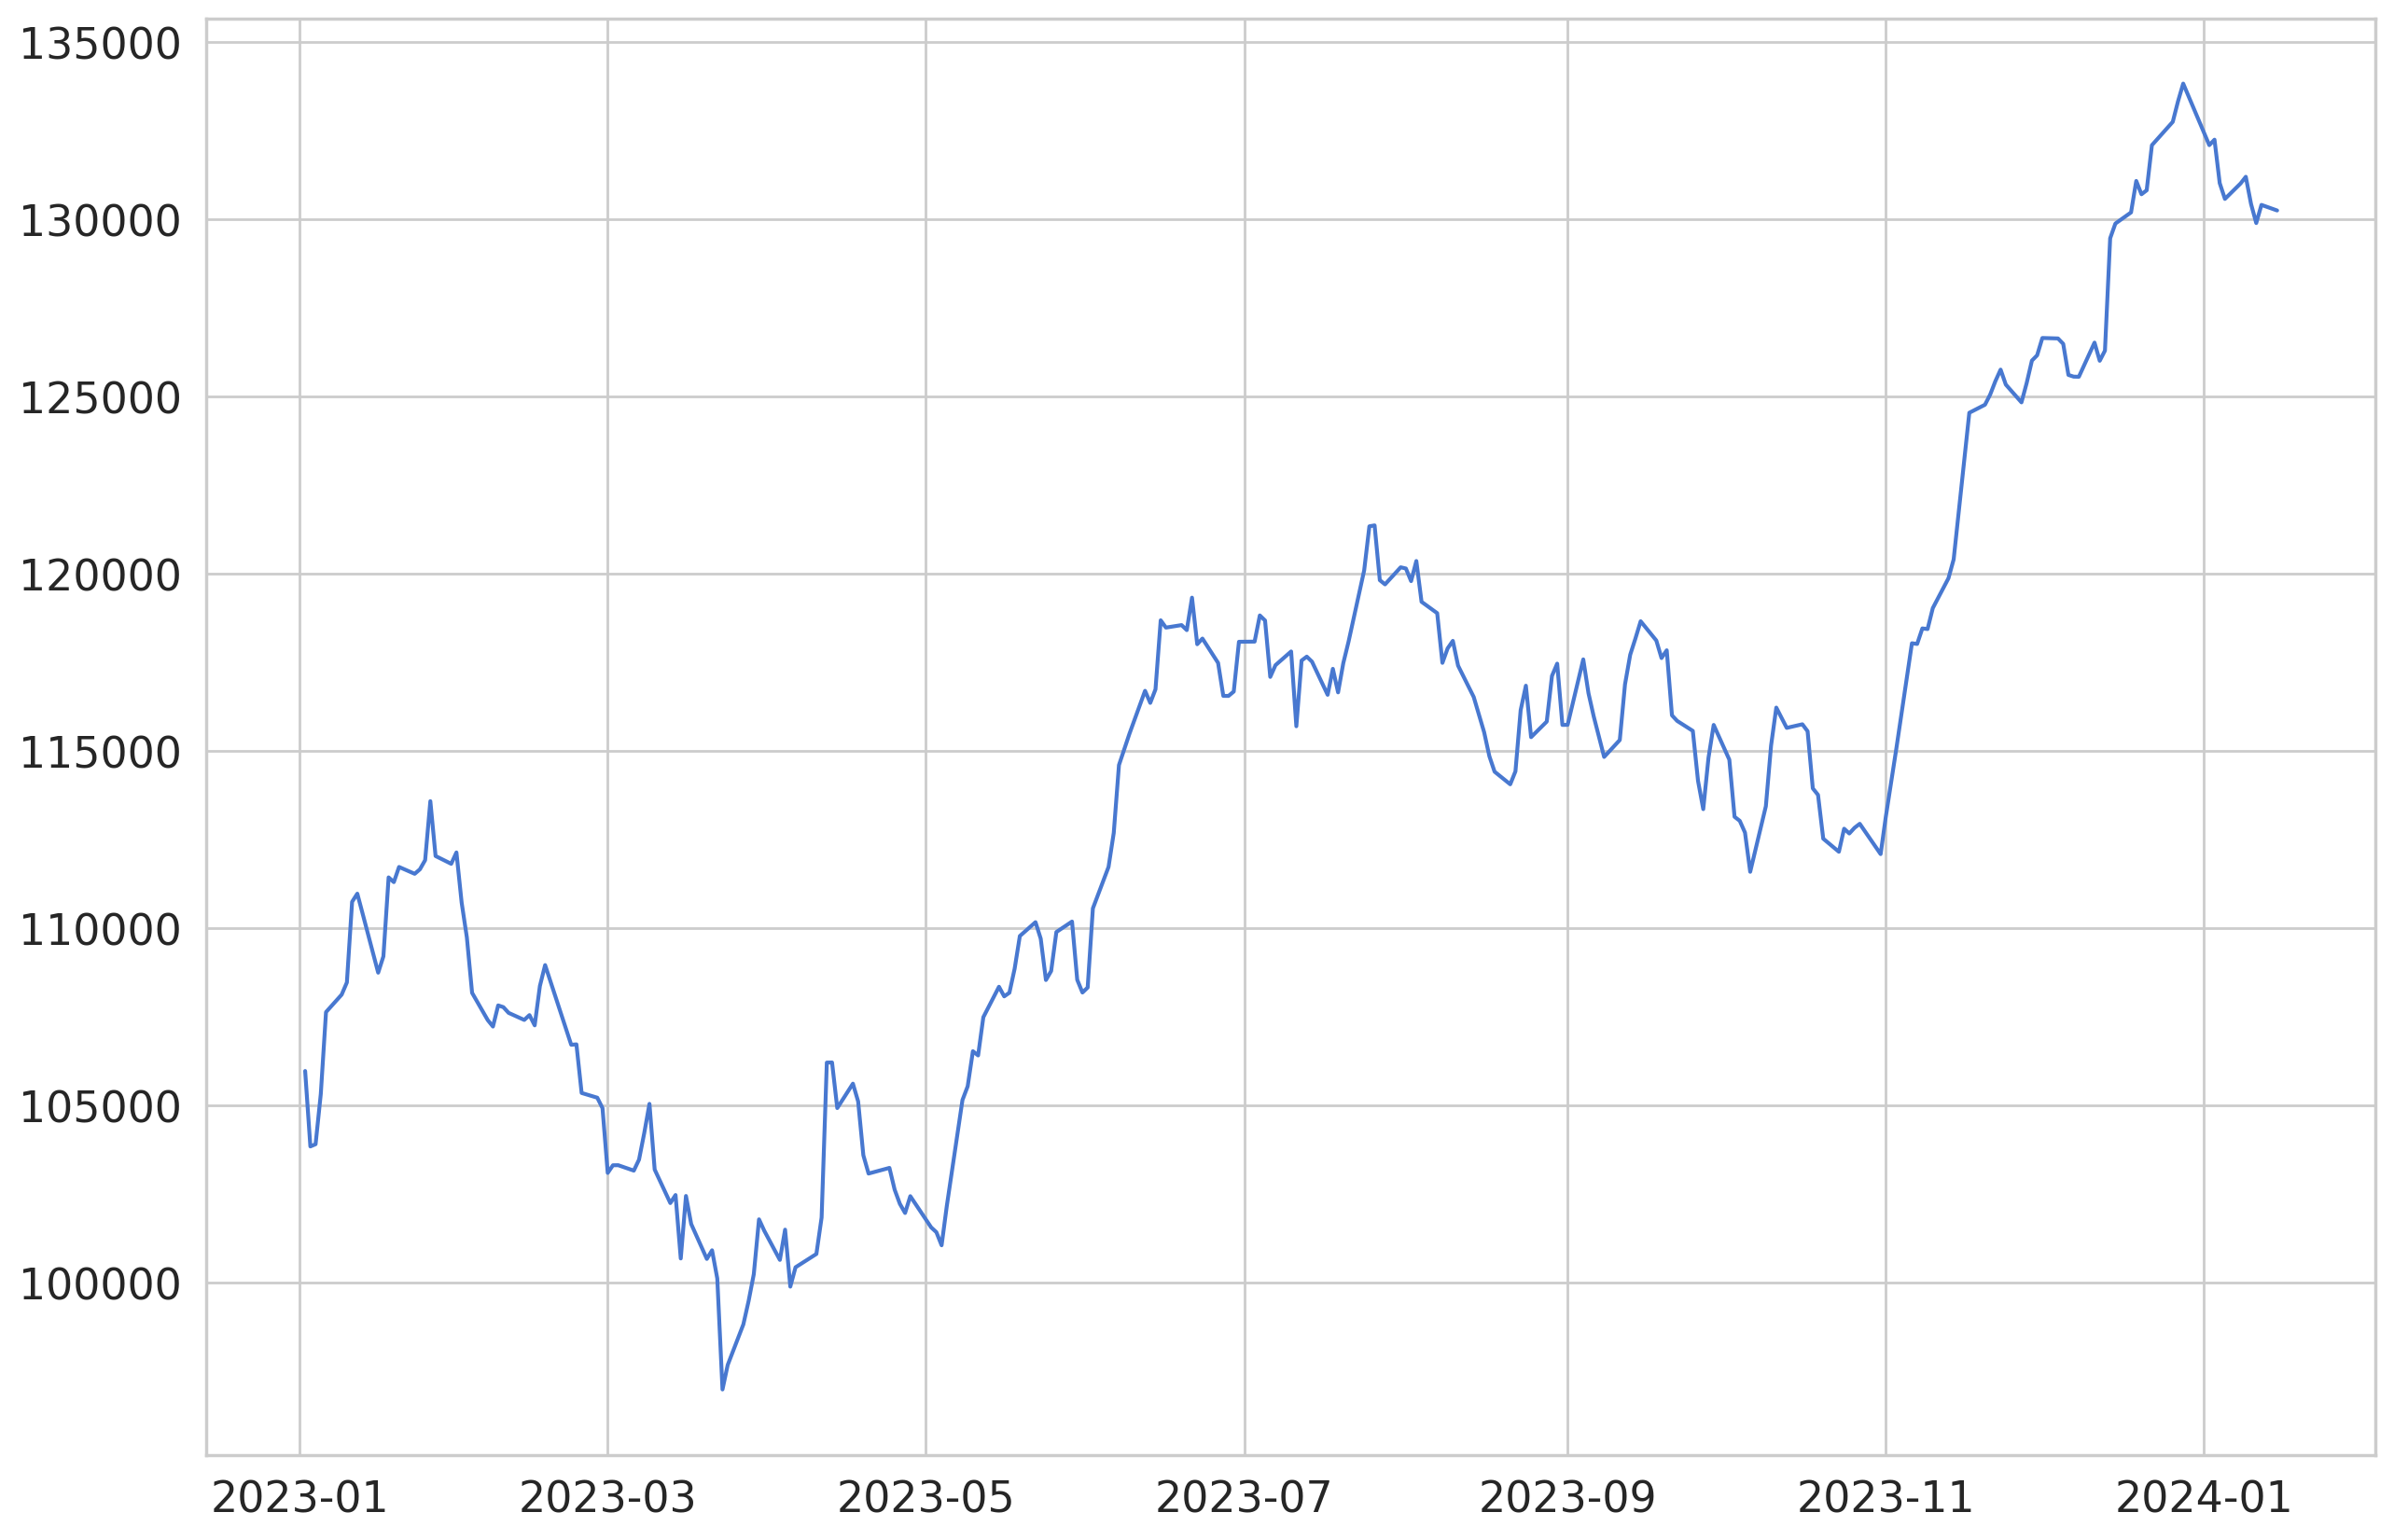

In [16]:
# Relação Date x Low (selecionar um período)

plt.figure(figsize = (15,10))
plt.plot(df['Date'], df['Low'], label='BVSP')

plt.show()

In [17]:
df['Adj Close'].isna().sum()

0

In [18]:
df['Adj Close'].tail()

253    131447.0
254    130841.0
255    130649.0
256    130988.0
257    131521.0
Name: Adj Close, dtype: float64

In [19]:
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Volume']

In [20]:
df.head(2)

,Date,Adj Close
0,2023-01-02,106376.0
1,2023-01-03,104166.0


In [21]:
df.shape

(258, 2)

 Aqui iniciamos o pré-processamento dos dados, para normalizar os valores de preços, optamos por usar a coluna 'Adj Close' pois é a coluna que mais bate com os dados reais.

In [22]:
adj_close = df['Adj Close'].values.reshape(-1, 1)

# Criando um Scaler, definindo o intervalo de 0 a 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustando o escalador aos dados e transformando-os
scaled_close = scaler.fit_transform(adj_close)

df['Scaled_Adj_Close'] = scaled_close

<Axes: ylabel='Density'>

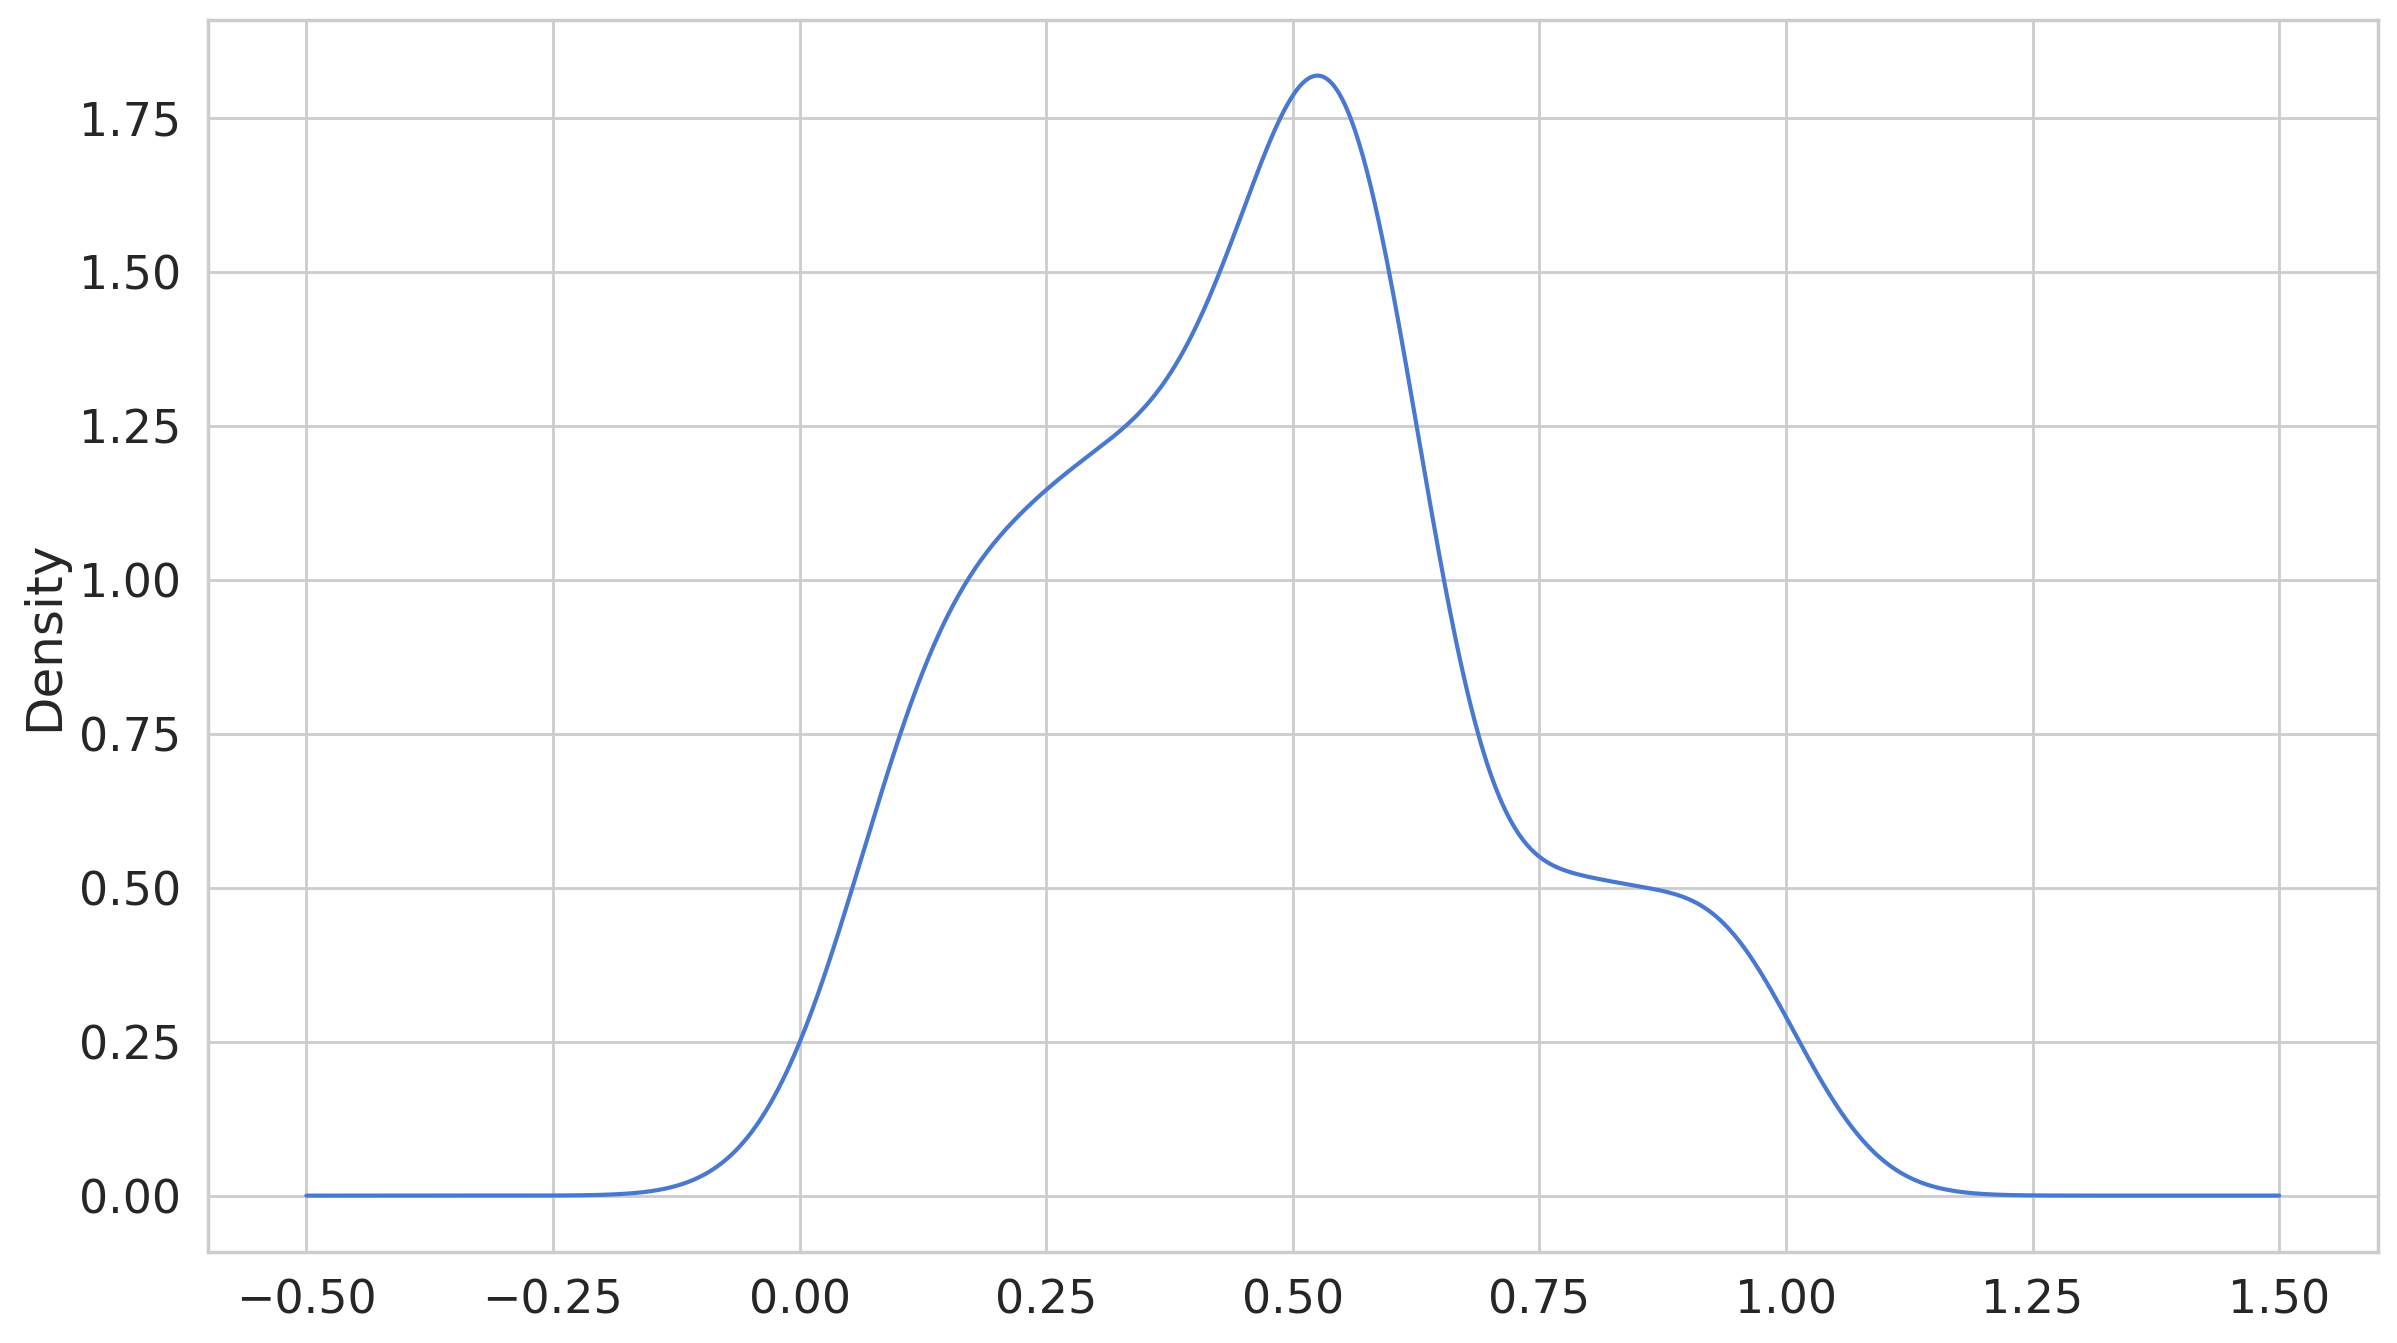

In [23]:
df['Scaled_Adj_Close'].plot(kind='kde')

 Essa normalização foi realizada para aprendizado de máquina para garantir que diferentes features estejam em escalas comparáveis.

# Prediction Stock Prices

Utilizamos um pipeline composto por funções para construir, treinar, gerar previsões e avaliar o desempenho de um modelo LSTM na previsão da bolsa de valores. A escolha da arquitetura LSTM, uma variante das Redes Neurais Recorrentes (RNNs), é baseada em características que se mostraram eficazes para lidar com dados temporais e sequenciais. Alguns motivos para essa escolha incluem:

- **Manejo de Sequencialidade**: RNNs, especialmente LSTMs, são adequadas para lidar com a natureza temporal das séries temporais da bolsa de valores, capturando padrões e dependências ao longo do tempo.

- **Memória de Longo Prazo**: LSTMs superam problemas de dependências temporais de longo prazo, sendo capazes de manter e atualizar a memória ao longo do tempo.

- **Tratamento de Dados Irregulares**: LSTMs podem aprender padrões complexos e se adaptar a mudanças repentinas, tornando-as robustas para lidar com a volatilidade e irregularidades dos dados da bolsa de valores.

- **Capacidade de Modelar Relações Não-Lineares**: LSTMs, com suas unidades de memória e portões, são capazes de modelar relações não-lineares complexas nos dados da bolsa de valores.

- **Aprendizado Contínuo**: RNNs, incluindo LSTMs, suportam o aprendizado contínuo, permitindo a adaptação do modelo a novas informações sem a necessidade de treinamento completo.

É crucial observar que, embora RNNs e LSTMs tenham se mostrado eficazes em tarefas temporais, a previsão da bolsa de valores é desafiadora devido à sua natureza incerta e influenciada por diversos fatores externos. O desempenho do modelo depende da qualidade e quantidade dos dados, sendo essencial realizar análises cuidadosas e considerar estratégias adicionais, como pré-processamento adequado e otimização de hiperparâmetros.

## Funções

In [41]:
def download_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

In [56]:
def preprocess_data(data, lookback_period, forecast_period, test_size=0.2, fetures=['Adj Close']):
    adj_close = []
    if len(fetures) == 1:
      adj_close = data[fetures].values.reshape(-1, 1)
    else:
      adj_close = data[fetures].values

    scaler = MinMaxScaler(feature_range=(0, len(fetures)))
    scaled_close = scaler.fit_transform(adj_close)

    X = []
    Y = []

    y = scaled_close

    for i in range(lookback_period, len(y) - forecast_period + 1):
        X.append(y[i - lookback_period: i])
        Y.append(y[i: i + forecast_period])

    X = np.array(X)
    Y = np.array(Y)
    return X, Y , scaler


In [59]:
def generate_forecasts(model, scaler, X_train, n_lookback):
    X_ = X_train.reshape(1, n_lookback, 1)
    Y_ = model.predict(X_).reshape(-1, 1)
    Y_ = scaler.inverse_transform(Y_)
    return Y_

In [61]:
def build_and_train_model(X_train, Y_train,X_test,Y_test, n_units, n_lookback, n_forecast, n_epochs, batch_size):
    model = Sequential()
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(n_lookback, 1)))
    model.add(LSTM(units=n_units))
    model.add(Dense(n_forecast))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train,validation_data = (X_test,Y_test), epochs=n_epochs, batch_size=batch_size, verbose=0)

    return model

## Parâmetros

In [40]:
# Definindo parametros

symbol = '^BVSP'
start_date = '2022-01-01'
end_date = '2024-01-18'
array_lookback_period = [30, 60] #[3,5,15, 30, 60] periodos menores tem menos acertividade
array_forecast_period = [3,4,5] #units: Positive integer, dimensionality of the output space.
array_n_units = [32,50]   # Inteiro positivo, dimensionalidade do espaço de saída.
array_batch_size = [64,100] # Número de amostras por atualização de gradiente. Se não for especificado, o padrão batch_size será 32. Não especifique o batch_size se seus dados estiverem na forma de conjuntos de dados, geradores ou instâncias keras.utils.Sequence (já que eles geram lotes).
n_epochs = 100 # Número de épocas para treinar o modelo. Uma época é uma iteração sobre todos os dados xey fornecidos (a menos que o sinalizador steps_per_epoch esteja definido como algo diferente de None). Observe que em conjunto com a época_inicial, as épocas devem ser entendidas como "época final". O modelo não é treinado para um número de iterações dadas por épocas, mas apenas até que a época das épocas do índice seja atingida.

In [46]:
# baixando dados atuais para comparação no futuro
data_actual = download_data(symbol, '2024-01-18', '2024-01-24')
data_actual =  data_actual[['Adj Close']]

data = download_data(symbol, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [47]:
del data['Open']
del data['High']
del data['Low']
del data['Close']
del data['Volume']
data.head(2)

,Adj Close
Date,
2022-01-03,103922.0
2022-01-04,103514.0


# Criando novas features

Descidimos utilizar Bandas de Bollinger que consiste em três linhas: a SMA (média móvel simples), uma banda superior e uma banda inferior. As bandas superior e inferior são calculadas em relação à SMA e ao desvio padrão dos preços de fechamento. Vamos  calcular as Bandas de Bollinger com um desvio padrão de 2 em relação à SMA de 20 dias (inputs padrões utilizado na plataforma https://br.investing.com/indices/bovespa-chart):

A ideia é adicionar essa nova feture para melhorar o modelo


In [48]:
n = 20  # Período da SMA
k = 2  # Número de desvios padrão

data['SMA'] = data['Adj Close'].rolling(window=n).mean()
data['Std'] = data['Adj Close'].rolling(window=n).std()

# Bandas de Bollinger
data['Upper_Bollinger'] = data['SMA'] + (k * data['Std'])
data['Lower_Bollinger'] = data['SMA'] - (k * data['Std'])
del data['Std']

<Axes: xlabel='Date'>

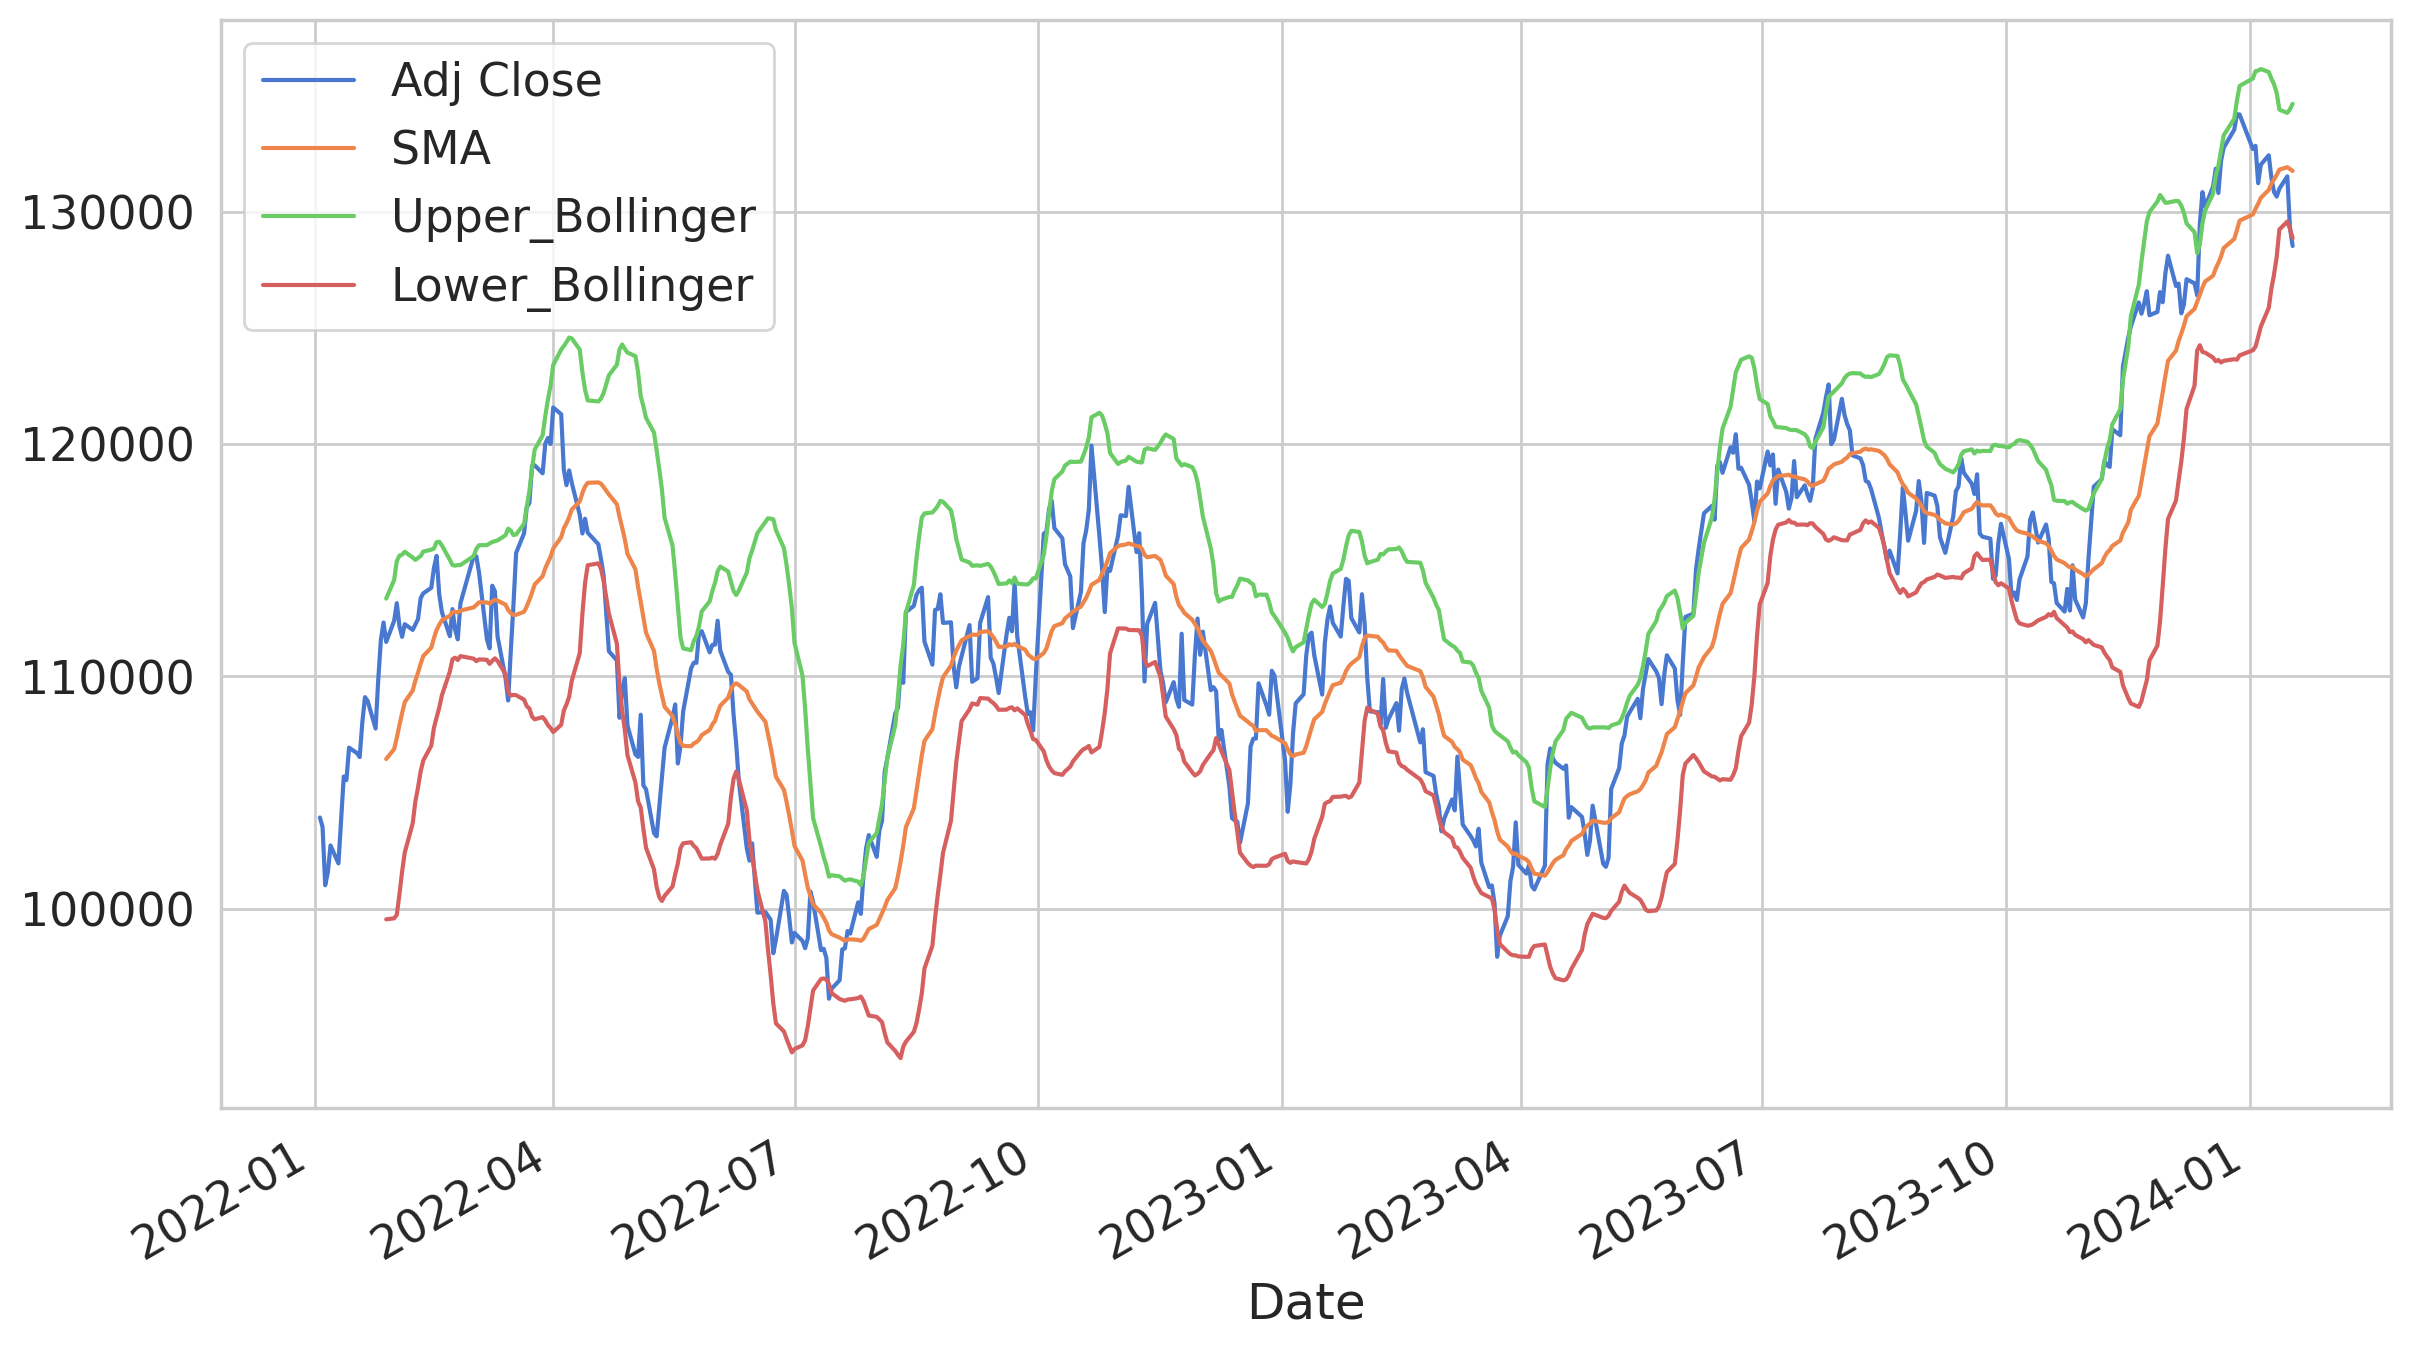

In [49]:
data.plot()

In [50]:
# como as Bandas de Bollinger iniciam depois de 20 dias, estamos removendo essas primeiras linhas nulas

data.dropna(inplace=True)

## Escolhendo os melhores parametros

In [ ]:
for lookback_period in array_lookback_period:
  for forecast_period in array_forecast_period:
    for n_units in array_n_units:
      for batch_size in array_batch_size:
        X_train, Y_train, scaler = preprocess_data(data, lookback_period, forecast_period)
        print(f'Tamanho do conjunto de treinamento (X_train): {len(X_train)}')
        model = build_and_train_model(X_train, Y_train, n_units, lookback_period, forecast_period, n_epochs, batch_size)
        forecasts = generate_forecasts(model, scaler, X_train[-1], _ ,lookback_period)
        print(forecasts)

In [52]:
fetures = ['Adj Close', 'SMA', 'Upper_Bollinger', 'Lower_Bollinger']
n_fetures = len(fetures)

In [54]:
# Parametros escolhidos apos os testes
lookback_period = 60
forecast_period = 3
n_units = 50
batch_size = 64
n_epochs = 200
n_fetures = len(fetures)

# Divisão em conjuntos de treino e teste

In [62]:
adj_close = []
if len(fetures) == 1:
  adj_close = data[fetures].values.reshape(-1, 1)
else:
  adj_close = data[fetures].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(adj_close)

X = []
Y = []

y = scaled_close

for i in range(lookback_period, len(y) - forecast_period + 1):
    X.append(y[i - lookback_period:i])
    Y.append(y[i:i + forecast_period])

X_train = np.array(X)
Y_train = np.array(Y)

# Divisão em conjuntos de treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [63]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (343, 60, 4)
Y_train shape: (343, 3, 4)
X_test shape: (86, 60, 4)
Y_test shape: (86, 3, 4)


# Modelo Final

In [64]:
# Modelo
model = Sequential()
model.add(LSTM(units=120, return_sequences=True, input_shape=(lookback_period, n_fetures)))
model.add(LSTM(units=n_units))
model.add(Dense(forecast_period * n_fetures)) # Ajustando a camada Dense
model.add(Reshape((forecast_period, n_fetures))) # Adicionando uma camada de redimensionamento
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 120)           60000     
                                                                 
 lstm_3 (LSTM)               (None, 50)                34200     
                                                                 
 dense_1 (Dense)             (None, 12)                612       
                                                                 
 reshape (Reshape)           (None, 3, 4)              0         
                                                                 
Total params: 94812 (370.36 KB)
Trainable params: 94812 (370.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Resultado do modelo

In [65]:
# Fazendo previsões
Y_pred = model.predict(X_test)

# Redimensionando Y_test e Y_pred para o cálculo do MSE
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1] * n_fetures)
Y_pred_reshaped = Y_pred.reshape(Y_pred.shape[0], Y_pred.shape[1] * n_fetures)

# Calculando o MSE
mse = mean_squared_error(Y_test_reshaped, Y_pred_reshaped)
print(f"MSE: {mse}")


3/3 [==============================] - 1s 28ms/step
MSE: 0.008223685046126762


In [71]:
import math
math.sqrt(0.008223685046126762)

0.09068453587093425

In [72]:
from sklearn.metrics import r2_score

# Calculando o R^2
r2 = r2_score(Y_test_reshaped, Y_pred_reshaped)
print(f"Coeficiente de Determinação (R^2): {r2}")


Coeficiente de Determinação (R^2): 0.7544322940449469


Um R² de 0.7544 significa que cerca de 75.44% da variância do conjunto de dados de teste é explicada pelo seu modelo. Isso indica que o modelo tem uma boa capacidade de prever os valores com base nos dados de entrada.


# Preparando dados para previsão e plot

In [73]:
# Preparando dados para previsão e plot
# Pegando os últimos 'lookback_period' pontos do DataFrame
last_points = data[fetures].tail(lookback_period)
last_points_scaled = scaler.transform(last_points)

X_predict = np.array([last_points_scaled])

predicted_scaled = model.predict(X_predict)

# Redimensionando as previsões para o formato usado no 'inverse_transform'
predicted_scaled = predicted_scaled.reshape(-1, len(fetures))

# Aplicar inverse_transform para converter as previsões de volta à escala original
predicted = scaler.inverse_transform(predicted_scaled)

# Converter as previsões em um DataFrame para facilitar a visualização/manipulação
predicted_df = pd.DataFrame(predicted, columns=fetures)
predicted_df

1/1 [==============================] - 0s 34ms/step


,Adj Close,SMA,Upper_Bollinger,Lower_Bollinger
0,126133.039062,128100.062500,127559.929688,130041.734375
1,125613.203125,128863.851562,124578.523438,129897.921875
2,124354.492188,126373.656250,123940.679688,130016.273438


In [74]:
# Selecionando os últimos pontos dos dados reais para plotar
real_data_to_plot = data.tail(lookback_period)

# Resetando os índices para facilitar a concatenação
real_data_to_plot = real_data_to_plot.reset_index(drop=True)
predicted_df = predicted_df.reset_index(drop=True)

# Concatenando os dados reais com as previsões
combined_data = pd.concat([real_data_to_plot, predicted_df], ignore_index=True)

### Real vs Predicted Stock Prices

Pudemos observar que o modelo é capaz de acompanhar uma tendência, no entanto, quando ocorre uma queda brusca seguida de uma recuperação, o modelo não consegue acompanhar essa dinâmica de forma eficaz.

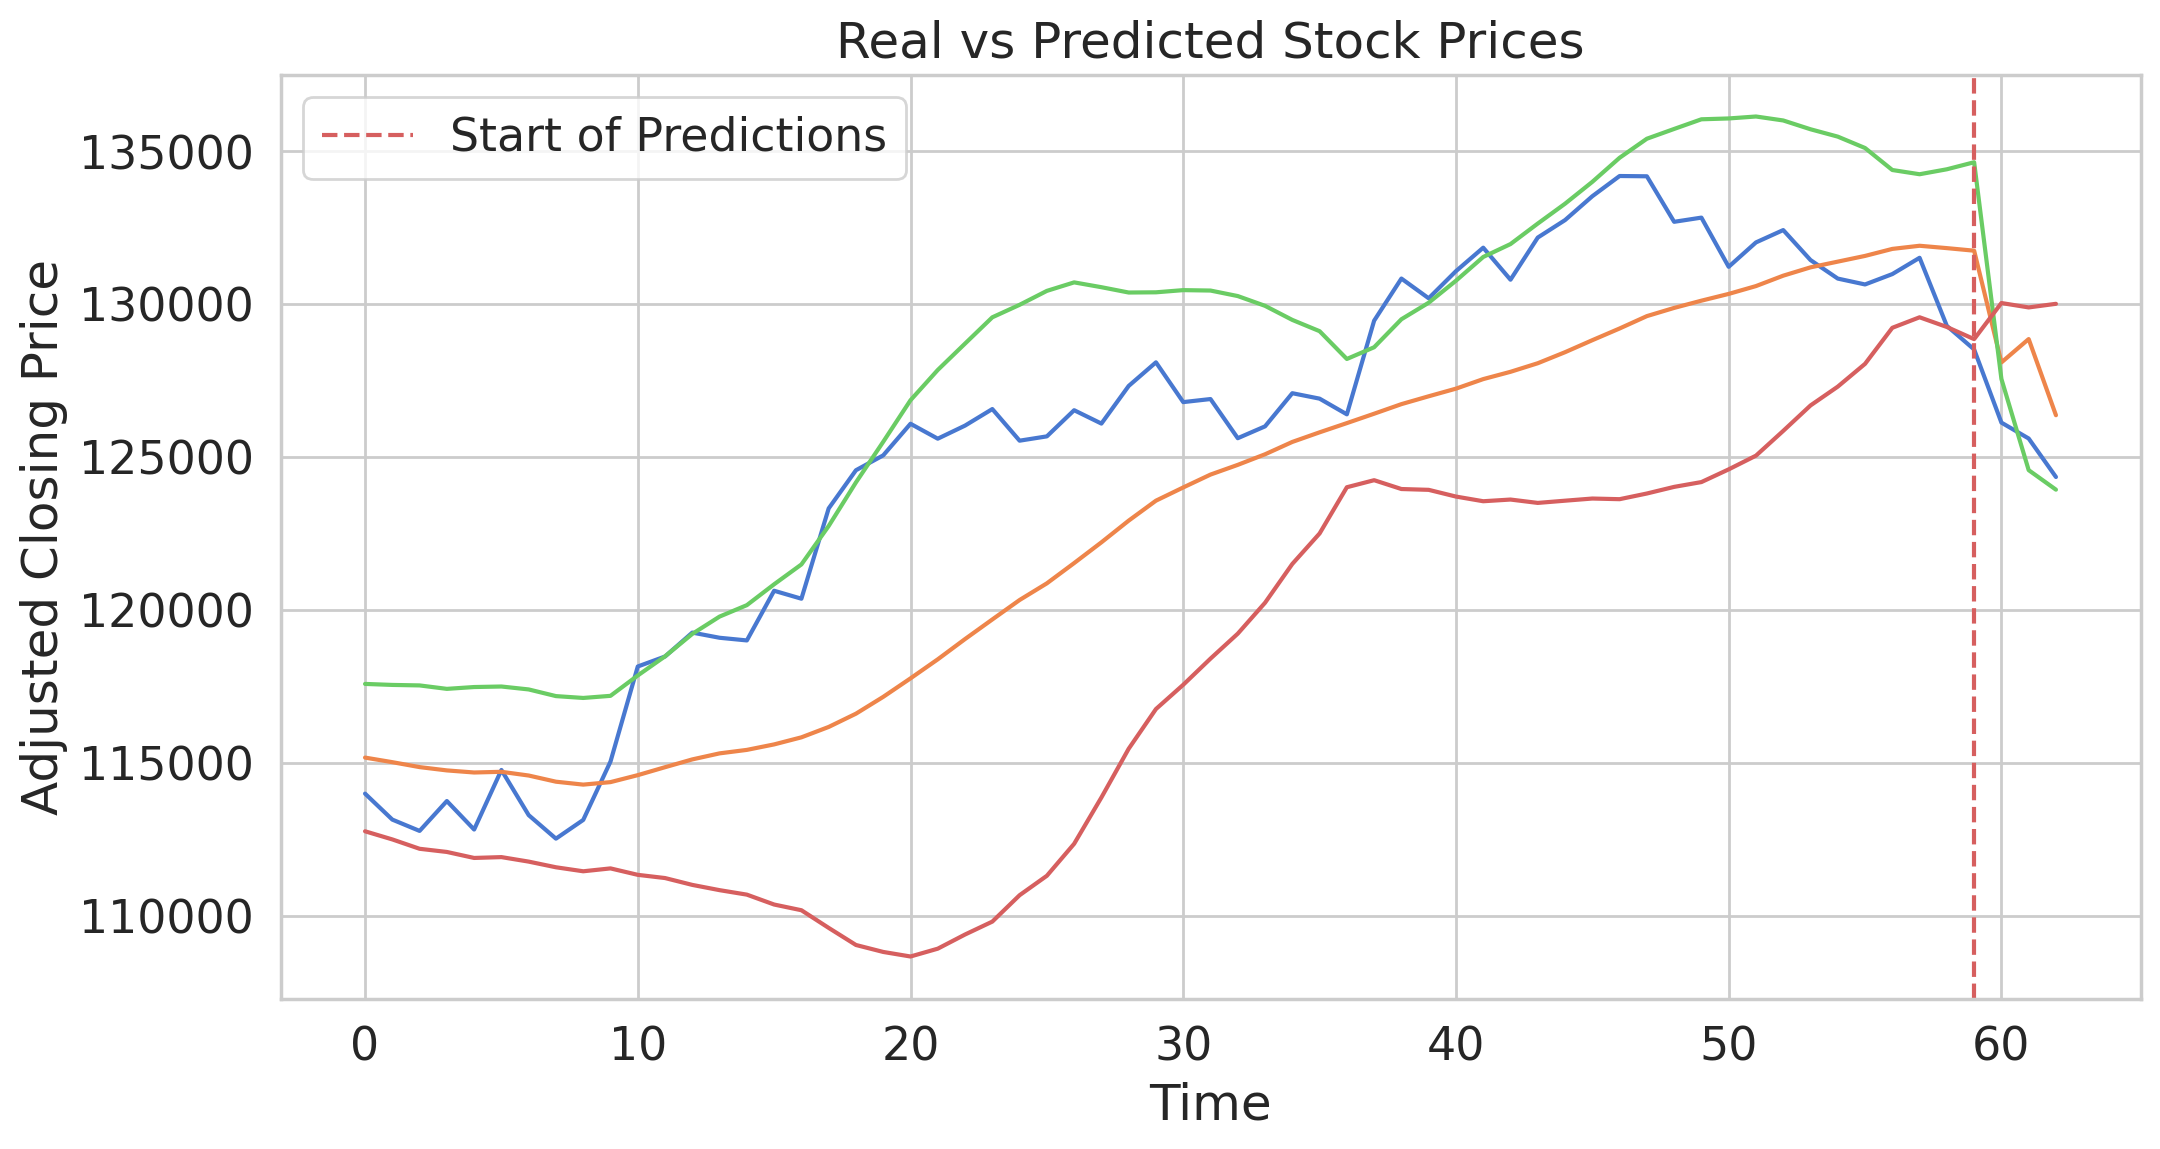

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(combined_data)
plt.axvline(x=lookback_period - 1, color='r', linestyle='--', label='Start of Predictions')
plt.title('Real vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.show()


In [76]:
predicted_df

,Adj Close,SMA,Upper_Bollinger,Lower_Bollinger
0,126133.039062,128100.062500,127559.929688,130041.734375
1,125613.203125,128863.851562,124578.523438,129897.921875
2,124354.492188,126373.656250,123940.679688,130016.273438


In [86]:
date_range = pd.date_range(start=data.reset_index()['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_period)
date_range

DatetimeIndex(['2024-01-18', '2024-01-19', '2024-01-20'], dtype='datetime64[ns]', freq='D')

In [138]:
date_min = date_range.min().strftime("%Y-%m-%d")
date_max = date_range.max().strftime("%Y-%m-%d")
print(date_min)
print(date_max)

2024-01-18
2024-01-20


In [139]:
df_atual = download_data(symbol, date_min, date_max)
df_atual = df_atual[['Adj Close']]
df_atual.rename(columns={'Adj Close': 'Atual'}, inplace=True)

[*********************100%%**********************]  1 of 1 completed


Montando um novo Data Frame para exibir os dados reais e os previstos

In [154]:
forecast_period = array_forecast_period[0]

df_past = data.reset_index()
df_past.rename(columns={'index': 'Date', 'Adj Close': 'Atual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Atual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Atual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_period)
df_future['Forecast'] = predicted_df['Adj Close']

df_future['Atual'] = np.nan

results = df_past.append(df_future).set_index('Date')

### Gráfico que mostra a previsão e os dados reais


In [141]:
# monta a data limite para utilizar na linha de corte do grafico
from datetime import datetime, timedelta
data_final = datetime.strptime(end_date, "%Y-%m-%d")
um_dia = timedelta(days=1)
data_resultado = data_final - um_dia
data_limite = data_resultado.strftime("%Y-%m-%d")


df_forcast = results[results.index > '2023-12-20']
fig = px.line(df_forcast, title='Real vs Predicted Stock Prices')

fig.add_vline(x=data_limite, line_dash="dash", line_color="red")

fig.show()

In [153]:
display(df_atual)
display(df_future[['Forecast']].head(2))

,Atual
Date,
2024-01-18,127316.0
2024-01-19,127636.0


,Forecast
0,126133.039062
1,125613.203125


# Conclusão

Após testarmos vários modelos, aquele que mais nos impressionou tanto em termos de resultados quanto em usabilidade foi o LSTM. Durante o processo, enfrentamos diversos desafios na previsão do índice Ibovespa. Talvez, se aplicarmos o modelo em ações de empresas onde seja possível identificar características que facilitem a previsão, como, por exemplo, algumas empresas brasileiras que têm uma grande influência no valor do dólar, poderíamos obter um desempenho ainda melhor na predição.

Outro ponto importante que observamos é que, ao realizar uma bateria de testes nos parâmetros, notamos que quanto mais dias eram previstos, pior o modelo se comportava. Portanto, optamos por mostrar apenas a previsão de 3 dias para auxiliar os investidores de curto prazo, fornecendo uma tendência mais clara.

